In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import charset_normalizer

## Data Loading
Load the original dataset from Google Drive.

In [41]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Project Objectives
This project aims to predict whether diabetic patients will be readmitted to the hospital, and further categorize them into within 30 days or after 30 days. Through EDA and feature engineering, we aim to build a machine learning model for identifying high-risk groups and providing insights for hospitals and insurance companies. However, this project targets to assist hospitals in efficiently allocating medical resources and accurately predicting readmission rates among diabetic patients.

- Objectives

  - For Insurance Companies: Adjust insurance-related parameters for each enrolled member based on features associated with high readmission risk.

  - For Hospitals: Modify treatment and discharge plans for high-risk patients to reduce hospital readmission rates.

  - Joint Goal: Enable stratified risk prediction to inform early interventions and tailored care strategies.

- Target Variable
  - Original: readmitted

  - Transformed to: readmit_level (categorical with three levels: 0 = no readmission, 1 = readmission)
  - Rationale: The original three-level classification (0 = no readmission, 1 = readmission after 30 days, 2 = readmission within 30 days) resulted in highly imbalanced data, with particularly low sample sizes in the 1 and 2 categories. This severely limited predictive performance. For practical purposes—whether from the hospital's perspective (avoiding patient harm and penalties) or the insurer's perspective (allocating resources efficiently)—high prediction accuracy is essential. Therefore, the two readmission categories were merged into a single "readmission" class to improve model performance and real-world utility.

- Unit of Analysis
  - Patient-level (each row represents a unique patient visit)

- Data Review and Preparation
  - Feature Review: Interpreted the meaning and distribution of available features; identified potential clinical and demographic relevance to readmission risk.

  - Handling Missing Values: Assessed missingness by variable; applied appropriate strategies (e.g., imputation or exclusion) based on type and proportion.

  - Handling Duplicates: Removed exact or near-duplicate patient records to ensure validity of patient-level analysis.

- Feature Engineering
  - Medication Categorization: Grouped medications based on pharmacological class to reduce dimensionality and capture drug-level treatment patterns.

  - Constructed Variables:

    - total_burden_score: Composite indicator reflecting number and type of comorbidities or interventions.

    - meds_per_day: Number of medications administered per inpatient day, representing treatment intensity.

    - is_public_high_burden: Boolean flag identifying publicly insured patients with high treatment burden, representing a socio-clinical risk group.

- Exploratory Data Analysis (EDA)
  - Target Variable Distribution: Assessed class balance in readmit_level to guide model choice and evaluation metrics.

  - Univariate Analysis: Examined variable distributions and outliers to inform potential transformations or binning.

  - Bivariate Analysis:

    - Explored associations between features and readmit_level using statistical tests and visualization.

    - Grouped rare categories, dropped irrelevant or redundant features, and evaluated variable relevance.

- Modeling Preparation and Selection
  - Based on EDA findings and project goals, selected two primary classification algorithms for modeling:

    - XGBoost: For its performance with imbalanced and structured data.

    - Random Forest: For its interpretability and feature importance estimation.

In [42]:
#import dataset
original_data = pd.read_csv('/content/drive/My Drive/diabetic_data.csv')
print(original_data.shape)

original_data.head(5)

(101766, 50)


encounter_id  patient_nbr             race  gender      age weight  \
0       2278392      8222157        Caucasian  Female   [0-10)      ?   
1        149190     55629189        Caucasian  Female  [10-20)      ?   
2         64410     86047875  AfricanAmerican  Female  [20-30)      ?   
3        500364     82442376        Caucasian    Male  [30-40)      ?   
4         16680     42519267        Caucasian    Male  [40-50)      ?   

   admission_type_id  discharge_disposition_id  admission_source_id  \
0                  6                        25                    1   
1                  1                         1                    7   
2                  1                         1                    7   
3                  1                         1                    7   
4                  1                         1                    7   

   time_in_hospital  ... citoglipton insulin  glyburide-metformin  \
0                 1  ...          No      No                   No   
1                 3  ...          No      Up                   No   
2                 2  ...          No      No                   No   
3                 2  ...          No      Up                   No   
4                 1  ...          No  Steady                   No   

   glipizide-metformin  glimepiride-pioglitazone  metformin-rosiglitazone  \
0                   No                        No                       No   
1                   No                        No                       No   
2                   No                        No                       No   
3                   No                        No                       No   
4                   No                        No                       No   

   metformin-pioglitazone  change diabetesMed readmitted  
0                      No      No          No         NO  
1                      No      Ch         Yes        >30  
2                      No      No         Yes         NO  
3                      No      Ch         Yes         NO  
4                      No      Ch         Yes         NO  

[5 rows x 50 columns]

Get familiar with the variables and make some assumptions:


*   Personal Info & Demographic
      *  patient_nbr(may existing duplicates)
      *  race
      *  gender
      *  age
      *  weight
*   Visit Info
      * encounter_id
      * admission_type_id(may correlated with 3,4,6)
      * discharge_disposition_id(may correlated with 2,4)
      * admission_source_id(may correlated with 2,3,6)
      * payer_code
      * medical_specialty(may correlated with 2,4)
      * time_in_hospital(may correlated with payer_code)
*   Diagnostics
      * num_lab_procedures
      * num_procedures
      * num_medications
      * number_outpatients
      * number_emergency
      * number_inpatient
      * diag_1
      * diag_2
      * diag_3
      * number_diagnoses
      * max_glu_serum
      * A1Cresult
*   Medications:(According to my background knowledge, I'd like to create new variables based on drug categories.):
      * Insulin Secretagogues
        * Sulfonylureas
        * Meglitinides
      * Insulin Sensitizers
      * Alpha-glucosidase Inhibitors
      * Biguanides
      * DPP-4 Inhibitors
      * Combination Drugs
      * Insulin
      * Examide combined with diuretics(presumably used due to complications indicated by `diag_2` and `diag_3`)
*   Treatment Change
      * change
      * diabetesMed




## Data Cleaning & Preprocessing
Handle missing values, duplicates and invalid categories.

From the description, we know that `admission_type_id` has no missing value, so the mapping is easier to understand.

In [43]:
admission_type_id = { 1 : 'Emergency'
, 2 : 'Urgent'
, 3 : 'Elective'
, 4 : 'Newborn'
, 5 : 'Not Available'
, 6 : 'NULL'
, 7 : 'Trauma Center'
, 8 : 'Not Mapped' }

In [44]:
original_data['admission_type'] = original_data['admission_type_id'].map(admission_type_id)
original_data.drop(columns = 'admission_type_id', inplace=True)

The same as `discharge_disposition_id`.

In [45]:
discharge_disposition_id = { 1 : 'Discharged to home'
, 2 : 'Discharged/transferred to another short term hospital'
, 3 : 'Discharged/transferred to SNF'
, 4 : 'Discharged/transferred to ICF'
, 5 : 'Discharged/transferred to another type of inpatient care institution'
, 6 : 'Discharged/transferred to home with home health service'
, 7 : 'Left AMA'
, 8 : 'Discharged/transferred to home under care of Home IV provider'
, 9 : 'Admitted as an inpatient to this hospital'
, 10 : 'Neonate discharged to another hospital for neonatal aftercare'
, 11 : 'Expired'
, 12 : 'Still patient or expected to return for outpatient services'
, 13 : 'Hospice / home'
, 14 : 'Hospice / medical facility'
, 15 : 'Discharged/transferred within this institution to Medicare approved swing bed'
, 16 : 'Discharged/transferred/referred another institution for outpatient services'
, 17 : 'Discharged/transferred/referred to this institution for outpatient services'
, 18 : 'NULL'
, 19 : 'Expired at home. Medicaid only, hospice'
, 20 : 'Expired in a medical facility. Medicaid only, hospice'
, 21 : 'Expired, place unknown. Medicaid only, hospice'
, 22 : 'Discharged/transferred to another rehab fac including rehab units of a hospital'
, 23 : 'Discharged/transferred to a long term care hospital'
, 24 : 'Discharged/transferred to a nursing facility certified under Medicaid but not certified under Medicare'
, 25 : 'Not Mapped'
, 26 : 'Unknown/Invalid'
, 30 : 'Discharged/transferred to another Type of Health Care Institution not Defined Elsewhere'
, 27 : 'Discharged/transferred to a federal health care facility'
, 28 : 'Discharged/transferred/referred to a psychiatric hospital of psychiatric distinct part unit of a hospital'
, 29 : 'Discharged/transferred to a Critical Access Hospital (CAH)' }

In [46]:
original_data['discharge_disposition'] = original_data['discharge_disposition_id'].map(discharge_disposition_id)
original_data.drop(columns = 'discharge_disposition_id', inplace=True)

The same as `admission_source_id`.

In [47]:
admission_source_id = { 1 : 'Physician Referral'
, 2 : 'Clinic Referral'
, 3 : 'HMO Referral'
, 4 : 'Transfer from a hospital'
, 5 : 'Transfer from a Skilled Nursing Facility (SNF)'
, 6 : 'Transfer from another health care facility'
, 7 : 'Emergency Room'
, 8 : 'Court/Law Enforcement'
, 9 :  'Not Available'
, 10 : 'Transfer from critial access hospital'
, 11 : 'Normal Delivery'
, 12 : 'Premature Delivery'
, 13 : 'Sick Baby'
, 14 : 'Extramural Birth'
, 15 : 'Not Available'
, 17 : 'NULL'
, 18 : 'Transfer From Another Home Health Agency'
, 19 : 'Readmission to Same Home Health Agency'
, 20 : 'Not Mapped'
, 21 : 'Unknown/Invalid'
, 22 : 'Transfer from hospital inpt/same fac reslt in a sep claim'
, 23 : 'Born inside this hospital'
, 24 : 'Born outside this hospital'
, 25 : 'Transfer from Ambulatory Surgery Center'
, 26 : 'Transfer from Hospice'
                      }

In [48]:
original_data['admission_source'] = original_data['admission_source_id'].map(admission_source_id)
original_data.drop(columns = 'admission_source_id', inplace=True)

According to the description, we know that `medical_specialty` has 84 different values, and it is recommended to reclassify it according to major medical categories.

In [49]:
def map_specialty(s):
    if pd.isna(s):
        return 'Unknown'
    s = s.lower()
    if 'pediatric' in s:
        return 'Pediatrics'
    elif 'obstetric' in s or 'gynecology' in s:
        return 'OB/GYN'
    elif 'surgery' in s or 'surgeon' in s:
        return 'Surgery'
    elif 'radiology' in s:
        return 'Radiology'
    elif 'psych' in s:
        return 'Psychiatry/Psychology'
    elif 'internal' in s or 'hospitalist' in s or 'osteopath' in s:
        return 'InternalMedicine'
    elif 'family' in s or 'general' in s:
        return 'PrimaryCare'
    elif 'cardio' in s:
        return 'Cardiology'
    elif 'neuro' in s:
        return 'Neurology'
    elif 'endocrinology' in s:
        return 'Endocrinology'
    elif 'nephro' in s:
        return 'Nephrology'
    elif 'gastro' in s:
        return 'Gastroenterology'
    elif 'orthopedic' in s:
        return 'Orthopedics'
    elif 'rehabilitation' in s:
        return 'Rehab'
    elif 'infectious' in s:
        return 'InfectiousDiseases'
    else:
        return 'Other'

original_data['specialty_group'] = original_data['medical_specialty'].apply(map_specialty)
original_data.drop(columns = 'medical_specialty', inplace=True)

According to the description, there are many values for `diag_1`, `diag_2`, and `diag_3`, more than 800, so we can try to merge these three values according to the main ICD-9 classification.

In [50]:
def map_icd9_category(diag):
    if pd.isna(diag):
        return 'Unknown'

    if diag.startswith('250'):
        return 'Diabetes'
    elif diag.startswith('E') or diag.startswith('V'):
        return 'External Causes'

    try:
        prefix = int(diag[:3])
    except:
        return 'Unknown'

    if 1 <= prefix <= 139:
        return 'Infectious and Parasitic Diseases'
    elif 140 <= prefix <= 239:
        return 'Neoplasms'
    elif 240 <= prefix <= 279 and not diag.startswith('250'):
        return 'Endocrine, Nutritional and Metabolic'
    elif 280 <= prefix <= 289:
        return 'Blood and Blood-forming Organs'
    elif 290 <= prefix <= 319:
        return 'Mental Disorders'
    elif 320 <= prefix <= 359:
        return 'Nervous System'
    elif 360 <= prefix <= 389:
        return 'Sense Organs'
    elif 390 <= prefix <= 459 or prefix == 785:
        return 'Circulatory System'
    elif 460 <= prefix <= 519 or prefix == 786:
        return 'Respiratory System'
    elif 520 <= prefix <= 579 or prefix == 787:
        return 'Digestive System'
    elif 580 <= prefix <= 629 or prefix == 788:
        return 'Genitourinary System'
    elif 630 <= prefix <= 679:
        return 'Pregnancy and Childbirth'
    elif 680 <= prefix <= 709 or prefix == 782:
        return 'Skin and Subcutaneous Tissue'
    elif 710 <= prefix <= 739:
        return 'Musculoskeletal System'
    elif prefix in [780, 781, 784] or 790 <= prefix <= 799:
        return 'Ill-defined Conditions'
    elif 800 <= prefix <= 999:
        return 'Injury and Poisoning'
    elif 740 <= prefix <= 759:
        return 'Congenital Anomalies'
    else:
        return 'Other'

for col in ['diag_1', 'diag_2', 'diag_3']:
    original_data[col + '_group'] = original_data[col].apply(map_icd9_category)

At the same time, to capture clinical complexity and interaction patterns between diagnoses, we created a combined feature using the three diagnosis groups (diag_1, diag_2, and diag_3). We also calculated the frequency of each unique combination to reflect how common or rare a specific diagnostic profile is across the population, which may be indicative of risk.

In [51]:
# Diagnosis tuple frequency
sorted_diag = original_data[['diag_1', 'diag_2', 'diag_3']].apply(lambda x: tuple(sorted(x.values)), axis=1)
original_data['diagnosis_tuple'] = sorted_diag.astype(str)
diag_freq = original_data['diagnosis_tuple'].value_counts().to_dict()
original_data['diagnosis_tuple_freq'] = original_data['diagnosis_tuple'].map(diag_freq)

In [52]:
original_data.drop(columns = ['diag_1', 'diag_2', 'diag_3'], inplace=True)

Our project is at the patient level, so we can drop `encounter_id`.

In [53]:
original_data.drop(columns = 'encounter_id', inplace=True)

### Missing Value Analysis
During data cleaning, we noticed that some columns had a high frequency of "?" values representing unknown or missing information. These values were replaced or consolidated appropriately for further analysis.

In [54]:
original_data = original_data.replace('?', np.nan)

To assess data completeness, we first calculate the number of NaN values in each column, along with the proportion of missing values relative to the total number of records.

In [55]:
#counting missing data
series = pd.Series(original_data.isnull().sum())
#calculate the percentage of missing data
print(series / original_data.shape[0] * 100)

patient_nbr                  0.000000
race                         2.233555
gender                       0.000000
age                          0.000000
weight                      96.858479
time_in_hospital             0.000000
payer_code                  39.557416
num_lab_procedures           0.000000
num_procedures               0.000000
num_medications              0.000000
number_outpatient            0.000000
number_emergency             0.000000
number_inpatient             0.000000
number_diagnoses             0.000000
max_glu_serum               94.746772
A1Cresult                   83.277322
metformin                    0.000000
repaglinide                  0.000000
nateglinide                  0.000000
chlorpropamide               0.000000
glimepiride                  0.000000
acetohexamide                0.000000
glipizide                    0.000000
glyburide                    0.000000
tolbutamide                  0.000000
pioglitazone                 0.000000
rosiglitazon

The columns `weight`, `max_glu_serum`, and `A1Cresult` have very high missing rates.

Only about 3.15% of the `weight` column contains usable values. Although it is a categorical variable described as weight in pounds, it does not represent BMI, and we lack height information to assess patient obesity. Since raw weight alone cannot be reliably linked to diabetes status, we recommend dropping this variable.

`max_glu_serum` and `A1Cresult` have approximately 5% and 17% of available values, respectively. Despite the high missingness (>80%), both are lab test results that provide valuable insights into a patient's blood glucose status—max_glu_serum reflects short-term glucose spikes, while A1Cresult indicates long-term glucose control.

Therefore, we recommend keeping both `max_glu_serum` and `A1Cresult` and treating their missing values as a separate category, labeled "Unknown", to retain this potentially critical information.

In [56]:
original_data['A1Cresult'] = original_data['A1Cresult'].fillna('Unknown')
original_data['max_glu_serum'] = original_data['max_glu_serum'].fillna('Unknown')
cleaning_data = original_data.drop('weight', axis=1)

cleaning_data.head()

patient_nbr             race  gender      age  time_in_hospital payer_code  \
0      8222157        Caucasian  Female   [0-10)                 1        NaN   
1     55629189        Caucasian  Female  [10-20)                 3        NaN   
2     86047875  AfricanAmerican  Female  [20-30)                 2        NaN   
3     82442376        Caucasian    Male  [30-40)                 2        NaN   
4     42519267        Caucasian    Male  [40-50)                 1        NaN   

   num_lab_procedures  num_procedures  num_medications  number_outpatient  \
0                  41               0                1                  0   
1                  59               0               18                  0   
2                  11               5               13                  2   
3                  44               1               16                  0   
4                  51               0                8                  0   

   ...  readmitted  admission_type  discharge_disposition    admission_source  \
0  ...          NO            NULL             Not Mapped  Physician Referral   
1  ...         >30       Emergency     Discharged to home      Emergency Room   
2  ...          NO       Emergency     Discharged to home      Emergency Room   
3  ...          NO       Emergency     Discharged to home      Emergency Room   
4  ...          NO       Emergency     Discharged to home      Emergency Room   

  specialty_group                          diag_1_group diag_2_group  \
0      Pediatrics                              Diabetes      Unknown   
1           Other  Endocrine, Nutritional and Metabolic     Diabetes   
2           Other              Pregnancy and Childbirth     Diabetes   
3           Other     Infectious and Parasitic Diseases     Diabetes   
4           Other                             Neoplasms    Neoplasms   

                           diag_3_group           diagnosis_tuple  \
0                               Unknown      ('250.83', '?', '?')   
1  Endocrine, Nutritional and Metabolic  ('250.01', '255', '276')   
2                       External Causes     ('250', '648', 'V27')   
3                    Circulatory System    ('250.43', '403', '8')   
4                              Diabetes     ('157', '197', '250')   

  diagnosis_tuple_freq  
0                    4  
1                    1  
2                    7  
3                    1  
4                    5  

[5 rows x 50 columns]

Next, we need to consider the variables `payer_code` and `race`.

`payer_code` may influence a patient's treatment decisions, length of stay, and risk of readmission. For example, self-pay diabetic patients—who bear medical expenses out of pocket—may experience financial pressure leading to early discharge before their condition is fully stabilized. This could increase the likelihood of readmission within 30 days.

`race` may also be related to diabetes onset or readmission risk due to genetic predispositions or other biological differences.

Therefore, for both variables, we recommend retaining them and converting missing values into a new category labeled "Unknown" to preserve this potentially important information.

In [57]:
cleaning_data['payer_code'] = cleaning_data['payer_code'].fillna('Unknown')
cleaning_data['race'] = cleaning_data['race'].fillna('Unknown')

### Handling Duplicate Records
Since the variable `patient_nbr` may appear multiple times in the dataset, we need to consider the reason for duplication:

Multiple hospital admissions (the same patient admitted more than once)

Data redundancy

First, we check whether there are duplicate values in `patient_nbr`.

In [58]:
cleaning_data['patient_nbr'].value_counts()

patient_nbr
88785891     40
43140906     28
88227540     23
1660293      23
23199021     23
             ..
174477542     1
38726739      1
77391171      1
89869032      1
63555939      1
Name: count, Length: 71518, dtype: int64

We found that some `patient_nbr` values do appear multiple times in the dataset.

As a first step, we remove fully duplicated rows—i.e., records where all column values are identical.

In [59]:
cleaning_data = cleaning_data.drop_duplicates()

print(cleaning_data.shape)

(101766, 50)


We observed that the number of rows in the dataset did not change after removing fully duplicated records, suggesting that the repeated `patient_nbr` values are likely due to multiple admissions rather than exact duplicates.

However, manual review is still recommended to verify this assumption.

In [60]:
duplicated_patient_nbr = cleaning_data[cleaning_data['patient_nbr'].duplicated(keep=False)]
duplicated_patient_nbr.sort_values(by='patient_nbr')

patient_nbr             race  gender      age  time_in_hospital  \
4780            135        Caucasian  Female  [50-60)                 3   
4267            135        Caucasian  Female  [50-60)                 8   
5953           1152  AfricanAmerican  Female  [50-60)                 6   
23623          1152  AfricanAmerican  Female  [60-70)                 8   
14180          1152  AfricanAmerican  Female  [60-70)                10   
...             ...              ...     ...      ...               ...   
95640     188634893        Caucasian    Male  [70-80)                 4   
93050     188970179            Asian  Female  [70-80)                 4   
101595    188970179            Asian  Female  [70-80)                 6   
90933     189257846            Asian    Male  [60-70)                 4   
98191     189257846            Asian    Male  [60-70)                 2   

       payer_code  num_lab_procedures  num_procedures  num_medications  \
4780      Unknown                  31               1               14   
4267      Unknown                  77               6               33   
5953      Unknown                  45               4               15   
23623     Unknown                  30               1               16   
14180     Unknown                  54               2               19   
...           ...                 ...             ...              ...   
95640          MC                  52               0               11   
93050          MC                  59               1               25   
101595         MC                  44               0               19   
90933          HM                  54               1               17   
98191          HM                  13               0               21   

        number_outpatient  ...  readmitted  admission_type  \
4780                    0  ...         >30       Emergency   
4267                    0  ...         <30          Urgent   
5953                    0  ...         >30       Emergency   
23623                   0  ...         >30       Emergency   
14180                   0  ...         >30       Emergency   
...                   ...  ...         ...             ...   
95640                   0  ...         >30        Elective   
93050                   0  ...         <30       Emergency   
101595                  0  ...          NO       Emergency   
90933                   0  ...          NO       Emergency   
98191                   0  ...         >30       Emergency   

                                    discharge_disposition    admission_source  \
4780                                   Discharged to home      Emergency Room   
4267                                   Discharged to home  Physician Referral   
5953                                   Discharged to home      Emergency Room   
23623                                  Discharged to home      Emergency Room   
14180                                  Discharged to home      Emergency Room   
...                                                   ...                 ...   
95640                                  Discharged to home  Physician Referral   
93050   Discharged/transferred to home with home healt...      Emergency Room   
101595                      Discharged/transferred to SNF      Emergency Room   
90933                                  Discharged to home      Emergency Room   
98191                                  Discharged to home      Emergency Room   

         specialty_group                          diag_1_group  \
4780             Surgery                  Injury and Poisoning   
4267          Cardiology                    Circulatory System   
5953               Other        Blood and Blood-forming Organs   
23623              Other        Blood and Blood-forming Organs   
14180              Other        Blood and Blood-forming Organs   
...                  ...                                   ...   
95640   InternalMedicine              

After confirming that the duplicates are not caused by data redundancy, we proceed to aggregate records with the same `patient_nbr`.

For categorical variables, we take the mode (most frequent value).

For numeric variables, we take the median instead of the mean, since all numeric variables in this dataset are discrete.

Special attention is needed for the target variable `readmitted`:
If any of the patient's encounters resulted in a readmission, the aggregated outcome should be marked as readmitted, to ensure we do not miss any positive cases.

In [61]:
print(cleaning_data.dtypes)

patient_nbr                  int64
race                        object
gender                      object
age                         object
time_in_hospital             int64
payer_code                  object
num_lab_procedures           int64
num_procedures               int64
num_medications              int64
number_outpatient            int64
number_emergency             int64
number_inpatient             int64
number_diagnoses             int64
max_glu_serum               object
A1Cresult                   object
metformin                   object
repaglinide                 object
nateglinide                 object
chlorpropamide              object
glimepiride                 object
acetohexamide               object
glipizide                   object
glyburide                   object
tolbutamide                 object
pioglitazone                object
rosiglitazone               object
acarbose                    object
miglitol                    object
troglitazone        

In [62]:
categorical_vars = cleaning_data.select_dtypes(include='object').columns
numeric_vars = cleaning_data.select_dtypes(include='int64').columns

numeric_vars = list(numeric_vars)
categorical_vars = list(categorical_vars)

The original readmitted variable includes three categories:

"<30" (readmitted within 30 days)

">30" (readmitted after 30 days)

"NO" (no readmission)

While a priority-based encoding (e.g., "<30" -> 2, ">30" -> 1, NO -> 0) was initially considered to reflect severity levels, this trichotomous approach led to significant class imbalance and poor model performance, particularly for the less frequent "<30" and ">30" categories.

To address this, we transformed readmitted into a binary target variable `readmit_level`:

1 = readmitted (regardless of time)

0 = no readmission

Later, we will group the dataset by `patient_nbr` using this target encoding during aggregation.


In [63]:
categorical_vars = [col for col in categorical_vars if col != "readmitted"]
numeric_vars = [col for col in numeric_vars if col != "patient_nbr"]

Encoding target variable

In [64]:
def classify_readmission(values):
    values = set(values)
    if 'NO' in values:
        return 0
    else:
        return 1

cleaning_data['readmit_level'] = cleaning_data.groupby('patient_nbr')['readmitted'].transform(classify_readmission)
cleaning_data.drop(columns = 'readmitted', inplace=True)

Perform aggregation

In [65]:
numeric_agg = {col: 'median' for col in numeric_vars}
categorical_agg = {col: lambda x: x.mode()[0] if len(x.mode()) > 0 else 'Unknown' for col in categorical_vars}
agg_funcs = {**numeric_agg, **categorical_agg, 'readmit_level': 'max'} #as this dataset doesn't have time variable.

df = cleaning_data.groupby('patient_nbr').agg(agg_funcs).reset_index()

While we used median and mode to summarize each patient's typical encounter profile, we additionally created aggregated sum/count features to capture cumulative healthcare utilization. This hybrid approach provides XGBoost both representative and longitudinal perspectives, enhancing its ability to identify patients at higher risk of readmission.

In [66]:
agg_df = cleaning_data.groupby('patient_nbr').agg({
    'time_in_hospital': 'sum',
    'num_lab_procedures': 'sum',
    'num_medications': 'sum'
}).rename(columns={
    'time_in_hospital': 'total_hospital_days',
    'num_lab_procedures': 'total_labs',
    'num_medications': 'total_meds'
})
df = df.merge(agg_df, on='patient_nbr', how='left')

In [67]:
print(df.shape)

df['patient_nbr'].value_counts()

(71518, 53)


patient_nbr
189502619    1
135          1
378          1
729          1
774          1
            ..
6723         1
6696         1
6309         1
6228         1
6174         1
Name: count, Length: 71518, dtype: int64

To simplify the analysis and capture more meaningful patterns, we create new features by merging individual drug variables according to their underlying mechanism of action (e.g., insulin secretagogues, insulin sensitizers, combination therapies, etc.).

Since both meglitinides and sulfonylureas fall under the category of insulin secretagogues, we want to examine the usage frequency of meglitinides.

If their usage is rare, we may consider merging them with sulfonylureas to avoid potential issues such as overfitting or model instability due to small sample size.

In [68]:
print(df[['repaglinide', 'nateglinide']].apply(lambda col: (col != 'No').sum()))

repaglinide    833
nateglinide    448
dtype: int64


There are 1,281 records involving meglitinide use, accounting for approximately 1.8% of the entire dataset.

Therefore, we recommend merging meglitinides with sulfonylureas under a unified insulin `secretagogue` category.

In [69]:
# Re-group
secretagogues = ['glimepiride', 'glipizide', 'glyburide', 'chlorpropamide', 'tolbutamide', 'tolazamide', 'acetohexamide', 'repaglinide', 'nateglinide']
sensitizers = ['metformin', 'pioglitazone', 'rosiglitazone', 'troglitazone', 'metformin-pioglitazone', 'metformin-rosiglitazone']
insulin_related = ['insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone']
alpha_glucosidase_inhibitors = ['acarbose', 'miglitol']
others = ['examide', 'citoglipton']  #rarely used drugs

def used_class(drugs_list, row):
    return any(row[drug] in ['Up', 'Down', 'Steady'] for drug in drugs_list if drug in row)

# Create new variables
df['uses_secretagogues'] = df.apply(lambda row: used_class(secretagogues, row), axis=1)
df['uses_sensitizer'] = df.apply(lambda row: used_class(sensitizers, row), axis=1)
df['uses_insulin_related'] = df.apply(lambda row: used_class(insulin_related, row), axis=1)
df['uses_alpha_glucosidase_inhibitor'] = df.apply(lambda row: used_class(alpha_glucosidase_inhibitors, row), axis=1)
df['uses_other_drugs'] = df.apply(lambda row: used_class(others, row), axis=1)

df.drop(columns = secretagogues + sensitizers + insulin_related + alpha_glucosidase_inhibitors + others, inplace=True)


In [70]:
df.head()

patient_nbr  time_in_hospital  num_lab_procedures  num_procedures  \
0          135               5.5                54.0             3.5   
1          378               2.0                49.0             1.0   
2          729               4.0                68.0             2.0   
3          774               3.0                46.0             0.0   
4          927               5.0                49.0             0.0   

   num_medications  number_outpatient  number_emergency  number_inpatient  \
0             23.5                0.0               0.0               0.5   
1             11.0                0.0               0.0               0.0   
2             23.0                0.0               0.0               0.0   
3             20.0                0.0               0.0               0.0   
4              5.0                0.0               0.0               0.0   

   number_diagnoses  diagnosis_tuple_freq  ...         diagnosis_tuple  \
0               6.5                   3.0  ...    ('250', '41', '998')   
1               3.0                  17.0  ...   ('250', '305', '722')   
2               9.0                   1.0  ...  ('493', '820', 'E880')   
3               9.0                   1.0  ...   ('274', '416', '427')   
4               3.0                   1.0  ...   ('220', '250', '590')   

  readmit_level total_hospital_days total_labs total_meds uses_secretagogues  \
0             1                  11        108         47               True   
1             0                   2         49         11              False   
2             0                   4         68         23              False   
3             0                   3         46         20               True   
4             0                   5         49          5               True   

  uses_sensitizer uses_insulin_related uses_alpha_glucosidase_inhibitor  \
0            True                False                            False   
1           False                False                            False   
2            True                False                            False   
3            True                False                            False   
4           False                False                            False   

  uses_other_drugs  
0            False  
1            False  
2            False  
3            False  
4            False  

[5 rows x 35 columns]

At this point, data preprocessing is complete.

# EDA & Feature Engineering

### Target Variable Balance Check
Before modeling, it's important to examine the distribution of the target variable `readmit_level` to determine whether the classes are balanced or imbalanced.

In [71]:
df['readmit_level'].value_counts(normalize=True)

readmit_level
0    0.76652
1    0.23348
Name: proportion, dtype: float64

While the target variable shows some degree of class imbalance, it is not severe enough to warrant immediate reclassification or merging. We will proceed with the original three-category outcome (<30, >30, NO) in the initial analysis.

## Univariate Analysis
We examine the distribution of **numerical** and **categorical** variables using appropriate plots such as histplot, countplot, and others.

In [72]:
print(df.dtypes)

patient_nbr                           int64
time_in_hospital                    float64
num_lab_procedures                  float64
num_procedures                      float64
num_medications                     float64
number_outpatient                   float64
number_emergency                    float64
number_inpatient                    float64
number_diagnoses                    float64
diagnosis_tuple_freq                float64
race                                 object
gender                               object
age                                  object
payer_code                           object
max_glu_serum                        object
A1Cresult                            object
change                               object
diabetesMed                          object
admission_type                       object
discharge_disposition                object
admission_source                     object
specialty_group                      object
diag_1_group                    

In [73]:
categorical_vars = df.select_dtypes(include=['object','bool']).columns.tolist()
numeric_vars = df.select_dtypes(include=['int64','float64']).columns.tolist()
for col in ['patient_nbr', 'readmit_level']:
    if col in numeric_vars:
        numeric_vars.remove(col)

* numeric variables

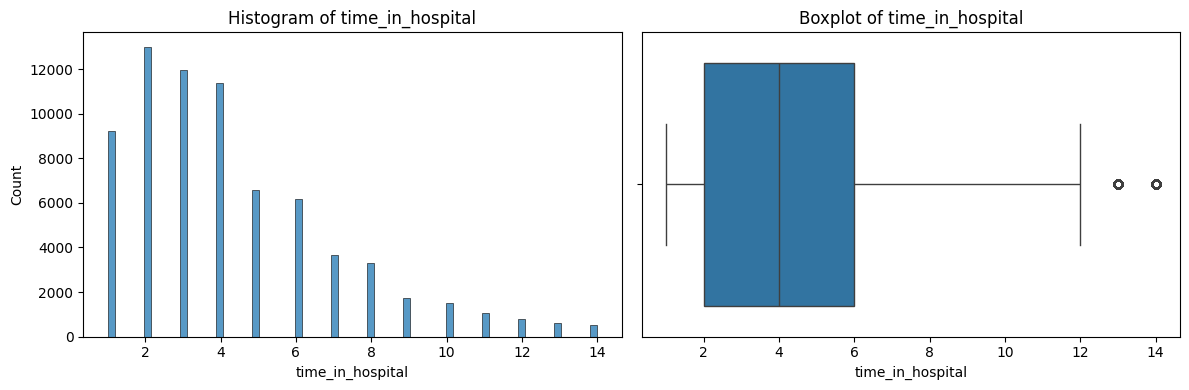

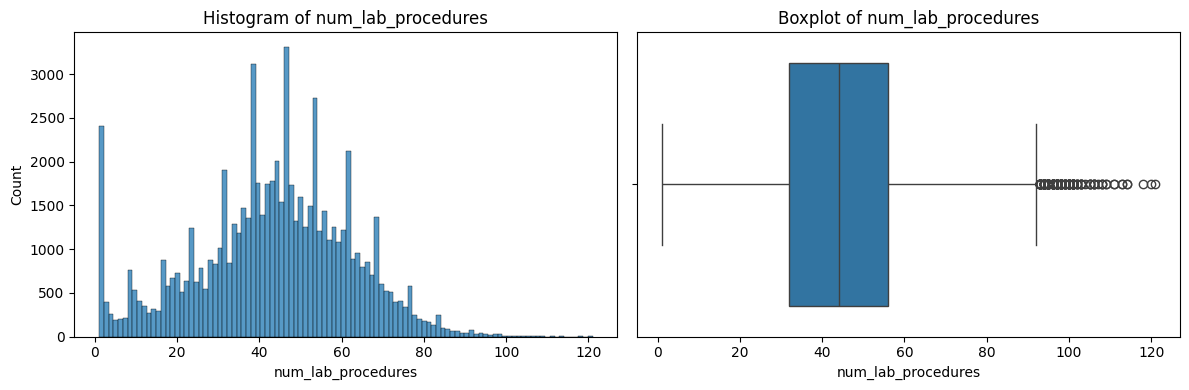

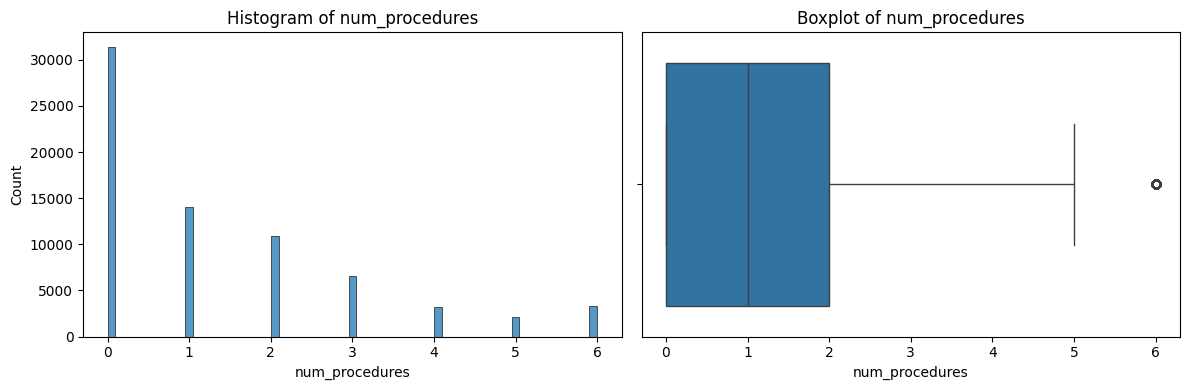

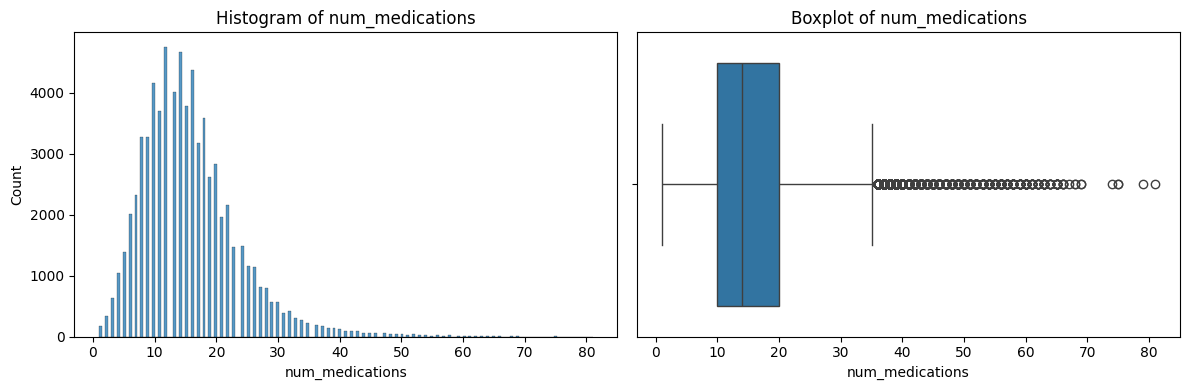

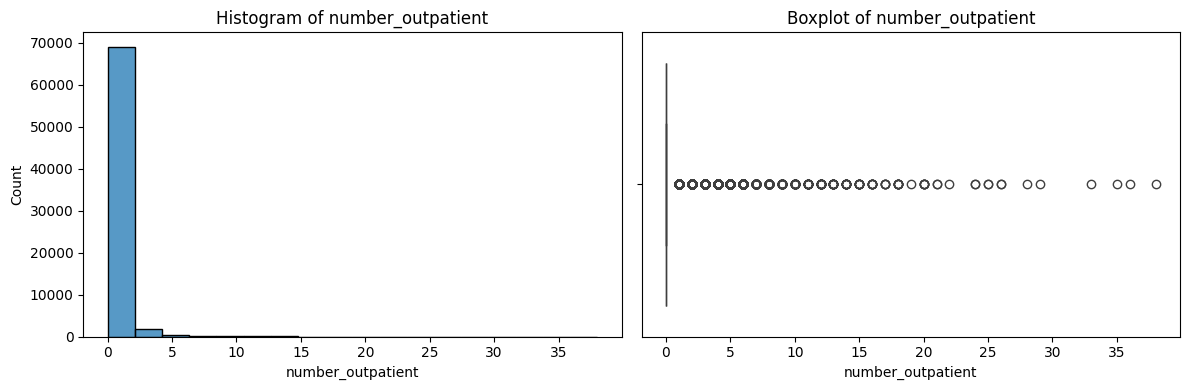

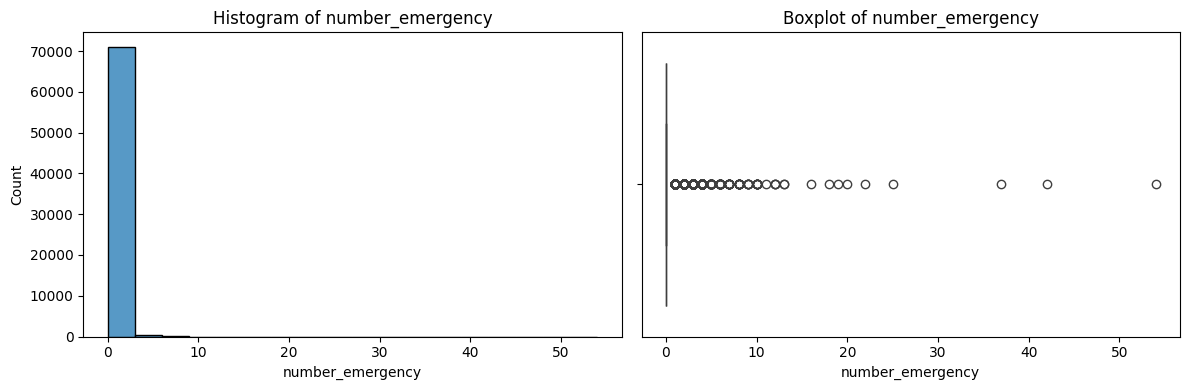

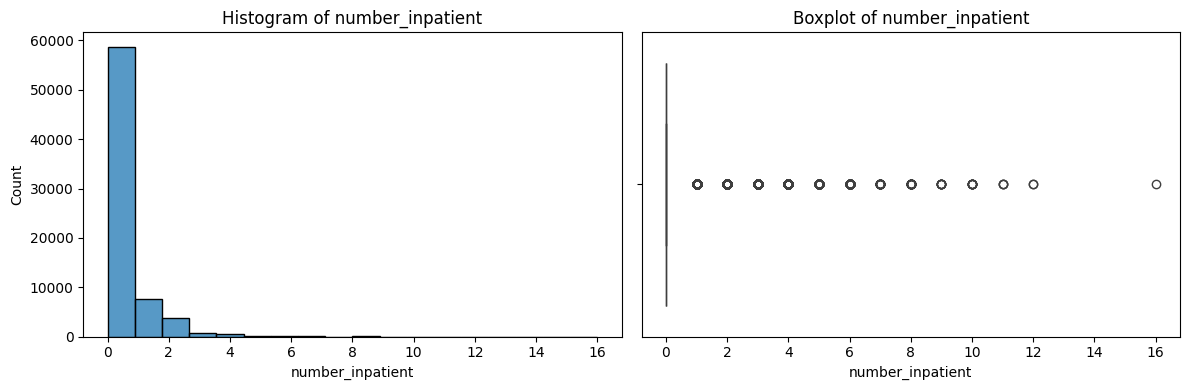

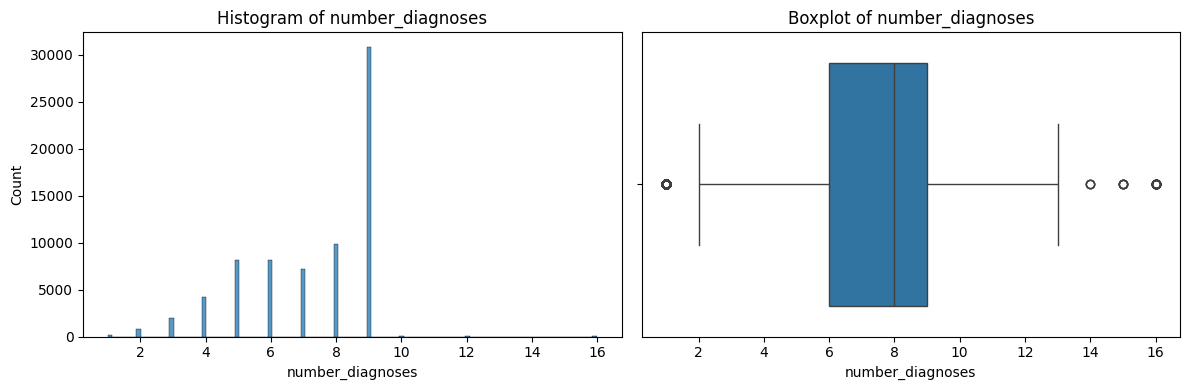

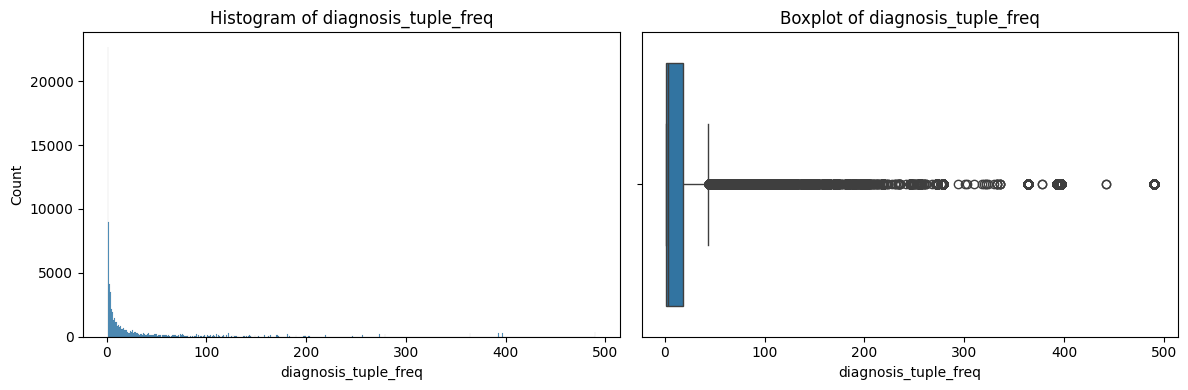

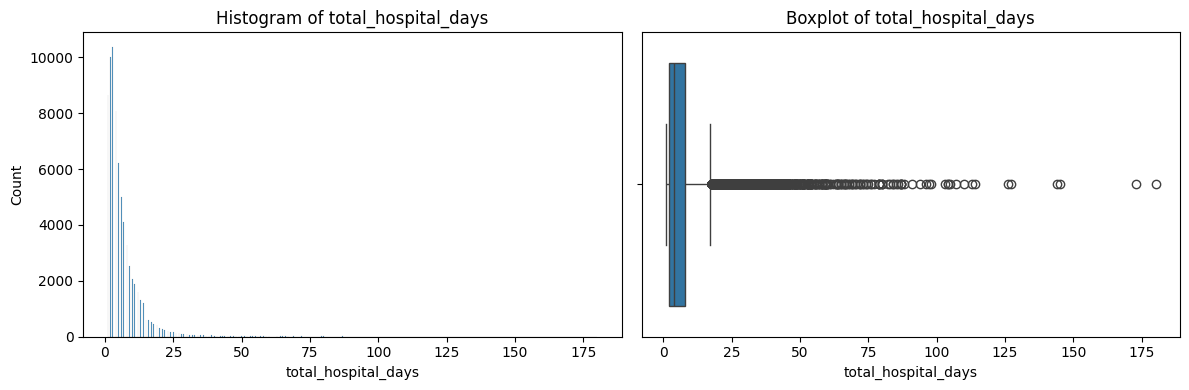

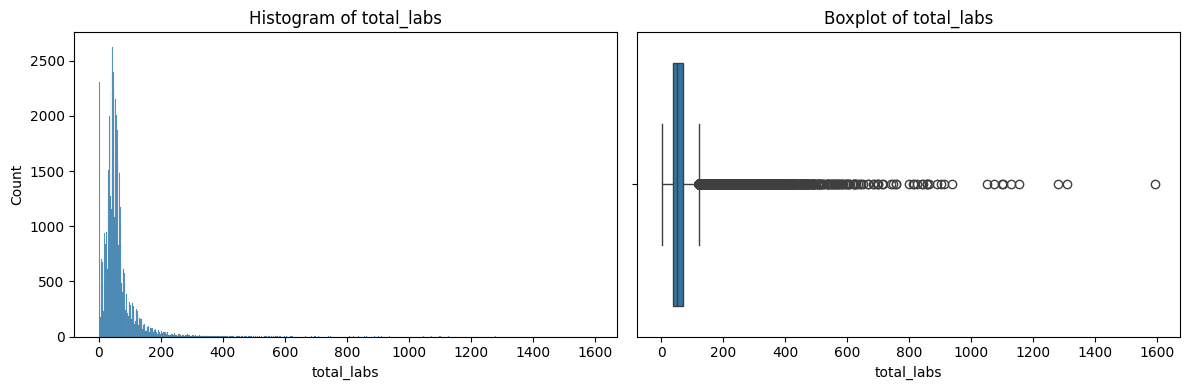

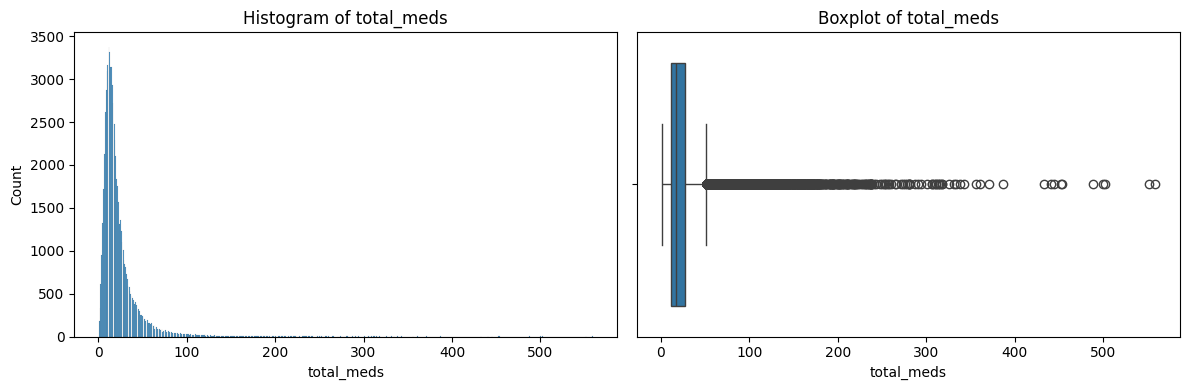

In [74]:
def plot_numeric_distributions(df, numeric_vars):
    for col in numeric_vars:
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))
        sns.histplot(df[col].dropna(), kde=False, ax=axes[0])
        axes[0].set_title(f'Histogram of {col}')

        sns.boxplot(x=df[col], ax=axes[1])
        axes[1].set_title(f'Boxplot of {col}')
        plt.tight_layout()
        plt.show()

for col in numeric_vars:
    df[col] = df[col].round().astype(int)
plot_numeric_distributions(df, numeric_vars)

Variable-Specific Processing Suggestions

- **`time_in_hospital`**  
  Not normally distributed (clearly right-skewed).  
  → Suggest keeping as-is. The range is narrow, so log transformation is not necessary. A few outliers exist, but the distribution is generally reasonable.

- **`num_lab_procedures`**  
  Not normally distributed → Avoid using t-tests; use non-parametric tests instead.  
  → Keep as-is. Extremely high values may result from grouped tests being ordered together, which is reasonable.

- **`num_procedures`**  
  Not normally distributed (mostly between 0–3).  
  → Can be kept as-is or treated as a categorical variable.

- **`num_medications`**  
  Right-skewed with many outliers.  
  → Do not drop outliers, but consider flagging high medication users, e.g., "num_medications > 40".

- **`number_outpatient`**, **`number_emergency`**, **`number_inpatient`**  
  All are non-normally distributed and mostly binary in nature.  
  → Recommend **binarizing** (e.g., `0` vs `≥1`) for bivariate analysis.

- **`number_diagnoses`**  
  Not normally distributed.  
  → Can be kept as-is or grouped into bins.

- **`diagnosis_tuple_freq`**: Extremely right-skewed with a heavy long tail.

  → Retain for modeling.

  → Consider creating a binary flag is_rare_tuple = (diagnosis_tuple_freq < 5) to capture rare diagnostic patterns.

  → Alternatively, bin into quantiles or use log-transform for interpretability.
- **`total_hospital_days`**: Highly skewed; majority of patients have <15 days total, with a few >100.

  → Retain.

  → Consider capping extreme values (e.g. 99th percentile) or log-transform if using non-tree models.

  → May also group into ordinal categories such as: low (0–5), moderate (6–20), high (>20).
- **`total_labs`**: Long-tailed distribution, values range from 0 to over 1500, with most patients <200.

  → Retain.

  → Consider creating a binary indicator for high utilization (e.g. labs_heavy = (total_labs > 200)), or cap at a reasonable threshold (e.g. 300–400).
- **`total_meds`**: Right-skewed with many outliers >300; median appears much lower.

  → Retain.

  → May construct an auxiliary variable for medication intensity (e.g. meds_heavy = (total_meds > 100)).

  → Consider binning or clipping extreme values, depending on modeling method.

We first binarize the three variables `number_outpatient`, `number_emergency`, and `number_inpatient`, and include them in the list of categorical variables for further distribution analysis.

The remaining numerical variables will be handled later during the modeling stage, based on their distribution and modeling needs.

In [75]:
sparse_vars = ['number_outpatient', 'number_emergency', 'number_inpatient']
for var in sparse_vars:
    new_var = f'has_{var.split("_")[1]}'
    df[new_var] = (df[var] > 0).astype(int)
    categorical_vars.append(new_var)

- categorical variables

In [76]:
def univariate_categorical_analysis(df, categorical_vars):
    for var in categorical_vars:
        # Frequency & Percentage
        freq_table = df[var].value_counts(dropna=False).to_frame(name='Count')
        freq_table['Percentage'] = (freq_table['Count'] / len(df)).round(4)
        display(freq_table)
        # Barplot visualization
        plt.figure(figsize=(8, 4))
        df[var].value_counts(dropna=False).plot(kind='bar')
        plt.title(f"Distribution of {var}")
        plt.xlabel(var)
        plt.ylabel("Count")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

Count  Percentage
race                              
Caucasian        53560      0.7489
AfricanAmerican  12924      0.1807
Unknown           1858      0.0260
Hispanic          1516      0.0212
Other             1155      0.0161
Asian              505      0.0071

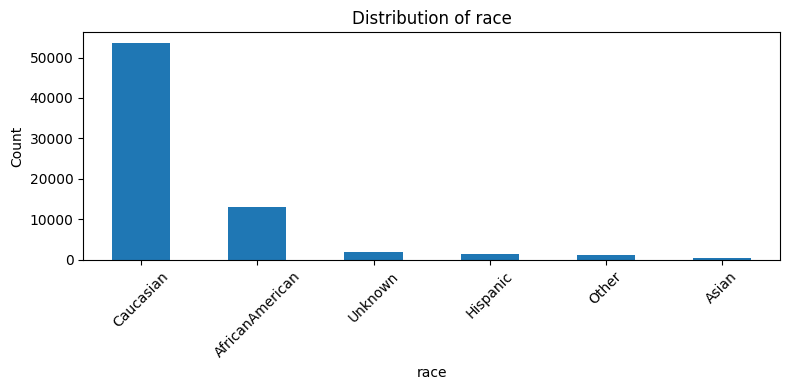

Count  Percentage
gender                            
Female           38025      0.5317
Male             33490      0.4683
Unknown/Invalid      3      0.0000

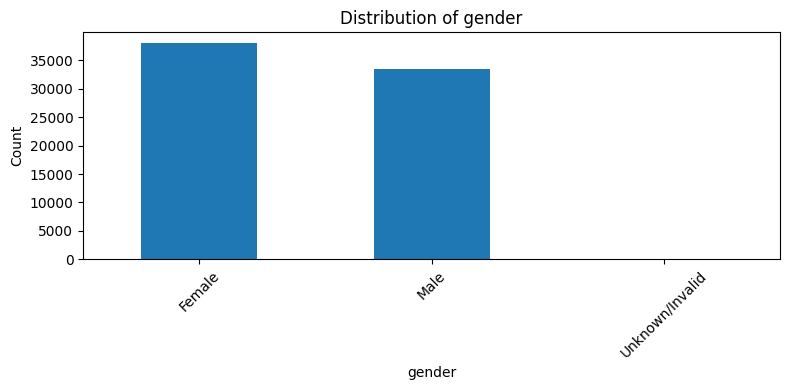

Count  Percentage
age                        
[70-80)   18203      0.2545
[60-70)   15946      0.2230
[50-60)   12459      0.1742
[80-90)   11637      0.1627
[40-50)    6837      0.0956
[30-40)    2691      0.0376
[90-100)   1941      0.0271
[20-30)    1117      0.0156
[10-20)     534      0.0075
[0-10)      153      0.0021

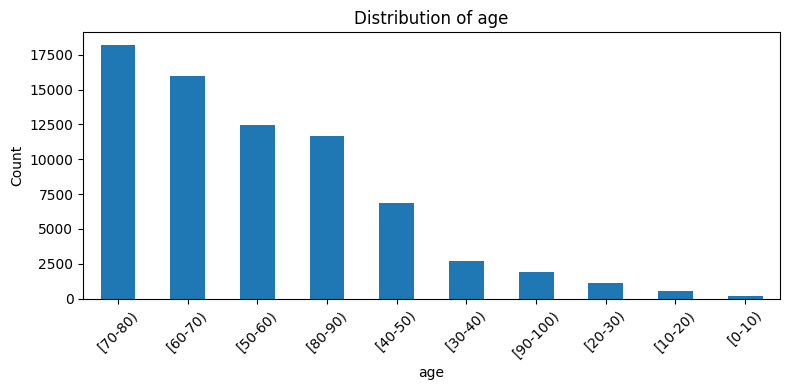

Count  Percentage
payer_code                   
Unknown     30186      0.4221
MC          21273      0.2974
HM           4180      0.0584
BC           3565      0.0498
SP           3045      0.0426
MD           2236      0.0313
CP           2000      0.0280
UN           1745      0.0244
CM           1425      0.0199
OG            660      0.0092
PO            445      0.0062
DM            395      0.0055
CH            123      0.0017
WC            108      0.0015
OT             64      0.0009
SI             34      0.0005
MP             33      0.0005
FR              1      0.0000

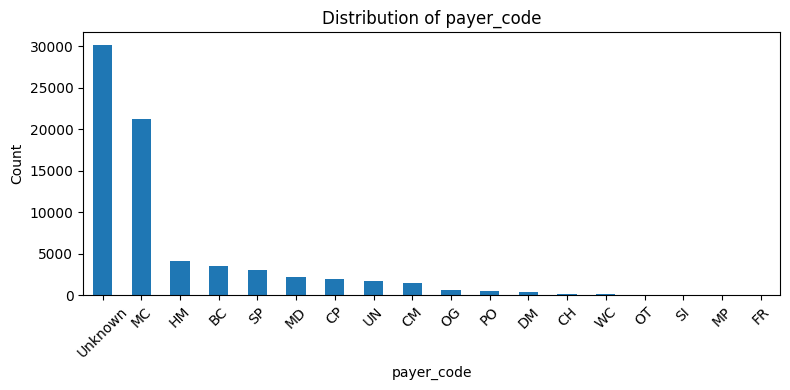

Count  Percentage
max_glu_serum                   
Unknown        68009      0.9509
Norm            1650      0.0231
>200            1122      0.0157
>300             737      0.0103

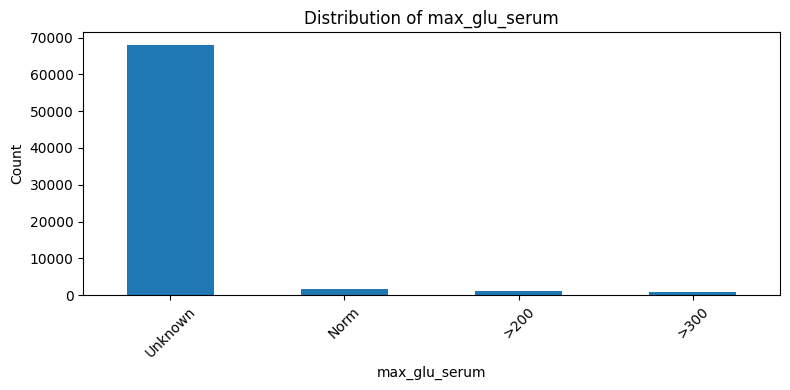

Count  Percentage
A1Cresult                   
Unknown    58076      0.8120
>8          6380      0.0892
Norm        3995      0.0559
>7          3067      0.0429

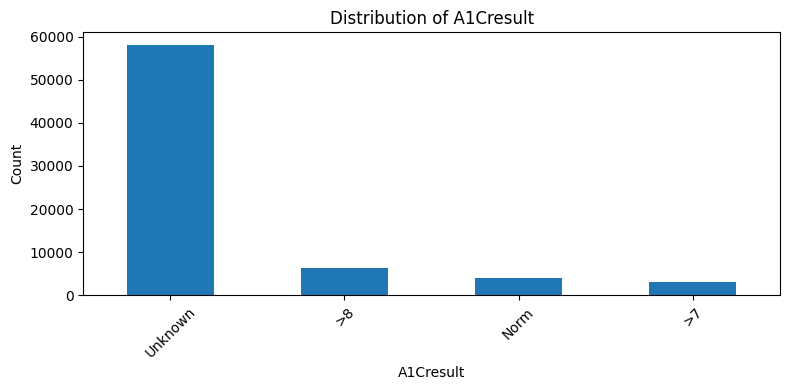

Count  Percentage
change                   
No      37610      0.5259
Ch      33908      0.4741

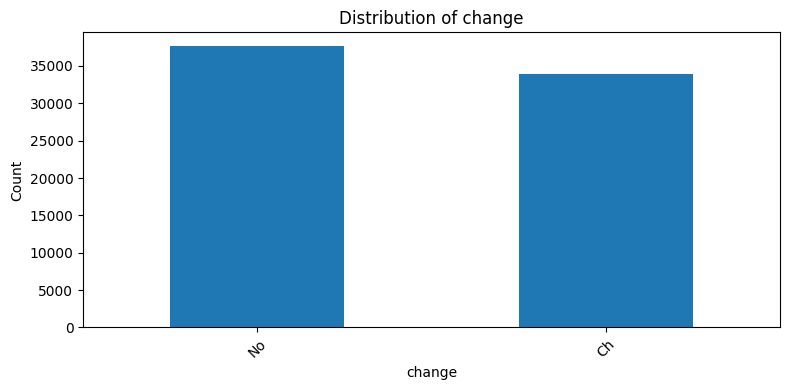

Count  Percentage
diabetesMed                   
Yes          53393      0.7466
No           18125      0.2534

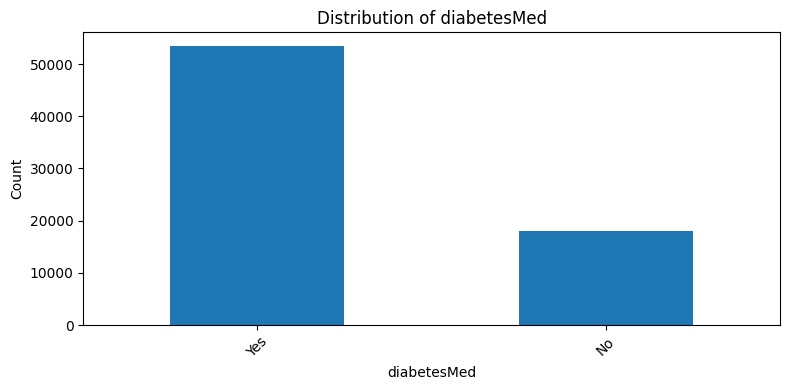

Count  Percentage
admission_type                   
Emergency       37186      0.5200
Elective        15007      0.2098
Urgent          11758      0.1644
NULL             4334      0.0606
Not Available    2922      0.0409
Not Mapped        282      0.0039
Trauma Center      19      0.0003
Newborn            10      0.0001

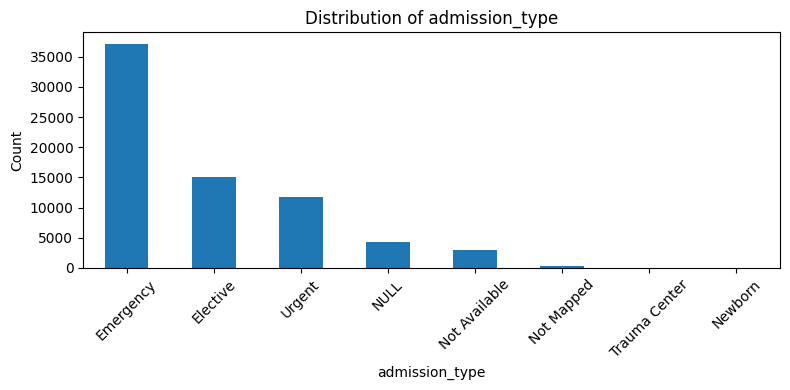

Count  Percentage
discharge_disposition                                                
Discharged to home                                  46100      0.6446
Discharged/transferred to SNF                        9085      0.1270
Discharged/transferred to home with home health...   7299      0.1021
NULL                                                 2333      0.0326
Discharged/transferred to another short term ho...   1294      0.0181
Discharged/transferred to another rehab fac inc...   1200      0.0168
Expired                                              1084      0.0152
Discharged/transferred to another type of inpat...    778      0.0109
Discharged/transferred to ICF                         576      0.0081
Not Mapped                                            534      0.0075
Left AMA                                              331      0.0046
Discharged/transferred to a long term care hosp...    242      0.0034
Hospice / home                                        239      0.0033
Hospice / medical facility                            214      0.0030
Discharged/transferred to home under care of Ho...     64      0.0009
Discharged/transferred/referred to a psychiatri...     56      0.0008
Discharged/transferred within this institution ...     24      0.0003
Discharged/transferred to a nursing facility ce...     23      0.0003
Admitted as an inpatient to this hospital              13      0.0002
Neonate discharged to another hospital for neon...      6      0.0001
Expired at home. Medicaid only, hospice                 6      0.0001
Discharged/transferred/referred to this institu...      6      0.0001
Discharged/transferred/referred another institu...      4      0.0001
Discharged/transferred to a federal health care...      4      0.0001
Still patient or expected to return for outpati...      2      0.0000
Expired in a medical facility. Medicaid only, h...      1      0.0000

/tmp/ipython-input-2366886152.py:14: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


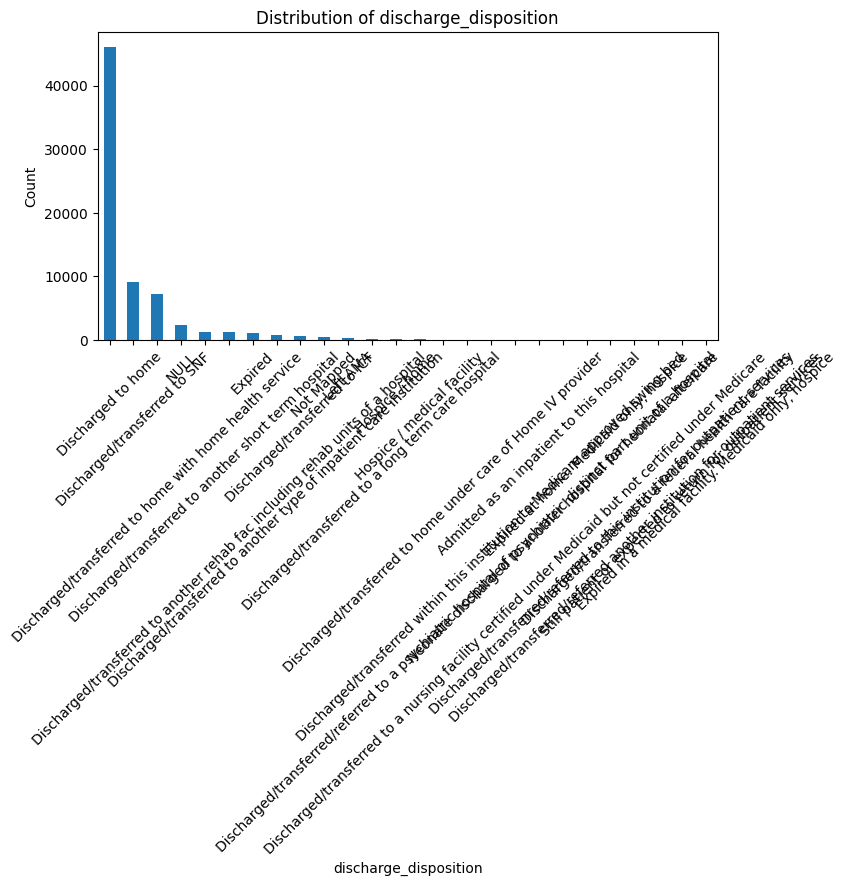

Count  Percentage
admission_source                                                     
Emergency Room                                      40570      0.5673
Physician Referral                                  20110      0.2812
NULL                                                 4918      0.0688
Transfer from a hospital                             2358      0.0330
Transfer from another health care facility           1679      0.0235
Clinic Referral                                       970      0.0136
Transfer from a Skilled Nursing Facility (SNF)        516      0.0072
Not Mapped                                            141      0.0020
HMO Referral                                          117      0.0016
Not Available                                         111      0.0016
Court/Law Enforcement                                  12      0.0002
Transfer from critial access hospital                   6      0.0001
Transfer from hospital inpt/same fac reslt in a...      3      0.0000
Extramural Birth                                        2      0.0000
Normal Delivery                                         2      0.0000
Transfer from Ambulatory Surgery Center                 2      0.0000
Sick Baby                                               1      0.0000

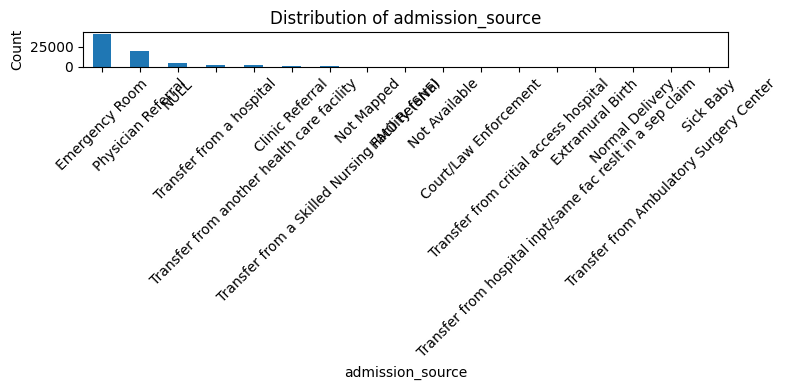

Count  Percentage
specialty_group                         
Other                  41746      0.5837
InternalMedicine       11515      0.1610
PrimaryCare             4639      0.0649
Cardiology              4525      0.0633
Surgery                 3316      0.0464
Orthopedics             2210      0.0309
Nephrology               892      0.0125
OB/GYN                   685      0.0096
Psychiatry/Psychology    612      0.0086
Pediatrics               439      0.0061
Gastroenterology         434      0.0061
Rehab                    170      0.0024
Neurology                170      0.0024
Endocrinology            103      0.0014
Radiology                 32      0.0004
InfectiousDiseases        30      0.0004

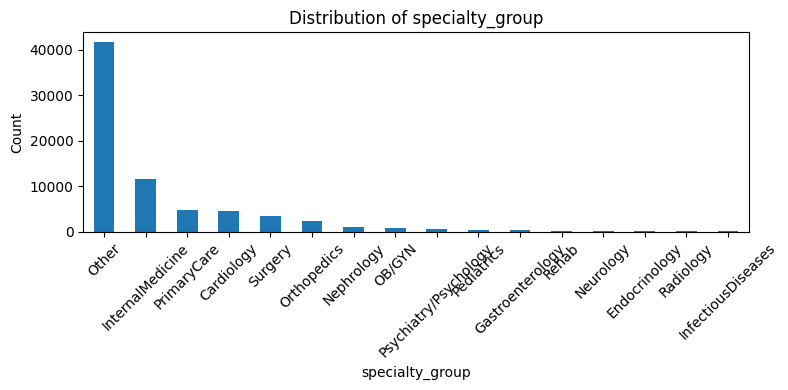

Count  Percentage
diag_1_group                                           
Circulatory System                    24060      0.3364
Respiratory System                     8706      0.1217
Digestive System                       6744      0.0943
Diabetes                               6075      0.0849
Injury and Poisoning                   4490      0.0628
Musculoskeletal System                 3669      0.0513
Genitourinary System                   3434      0.0480
Neoplasms                              2522      0.0353
Endocrine, Nutritional and Metabolic   1832      0.0256
Infectious and Parasitic Diseases      1716      0.0240
Ill-defined Conditions                 1649      0.0231
Skin and Subcutaneous Tissue           1515      0.0212
Mental Disorders                       1498      0.0209
External Causes                        1052      0.0147
Blood and Blood-forming Organs          842      0.0118
Nervous System                          590      0.0082
Pregnancy and Childbirth                580      0.0081
Other                                   311      0.0043
Sense Organs                            182      0.0025
Congenital Anomalies                     42      0.0006
Unknown                                   9      0.0001

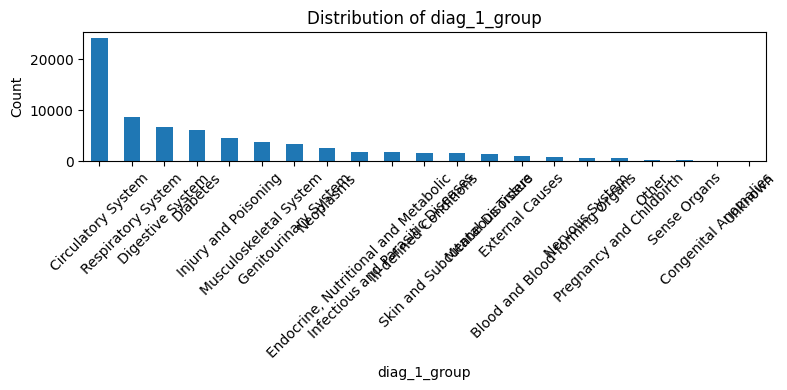

Count  Percentage
diag_2_group                                           
Circulatory System                    24996      0.3495
Diabetes                               9778      0.1367
Respiratory System                     6438      0.0900
Endocrine, Nutritional and Metabolic   5537      0.0774
Genitourinary System                   5142      0.0719
Digestive System                       2903      0.0406
Blood and Blood-forming Organs         2508      0.0351
Skin and Subcutaneous Tissue           1925      0.0269
External Causes                        1714      0.0240
Mental Disorders                       1707      0.0239
Neoplasms                              1675      0.0234
Injury and Poisoning                   1647      0.0230
Ill-defined Conditions                 1561      0.0218
Infectious and Parasitic Diseases      1149      0.0161
Musculoskeletal System                 1144      0.0160
Nervous System                          695      0.0097
Pregnancy and Childbirth                350      0.0049
Unknown                                 262      0.0037
Other                                   198      0.0028
Sense Organs                             99      0.0014
Congenital Anomalies                     90      0.0013

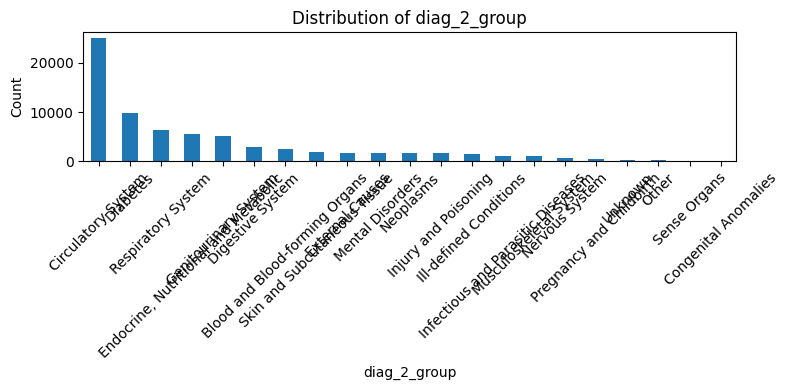

Count  Percentage
diag_3_group                                           
Circulatory System                    24315      0.3400
Diabetes                              12855      0.1797
Endocrine, Nutritional and Metabolic   6290      0.0879
Respiratory System                     4072      0.0569
Genitourinary System                   3825      0.0535
External Causes                        3255      0.0455
Digestive System                       2689      0.0376
Blood and Blood-forming Organs         2140      0.0299
Mental Disorders                       1899      0.0266
Ill-defined Conditions                 1435      0.0201
Skin and Subcutaneous Tissue           1329      0.0186
Injury and Poisoning                   1241      0.0174
Neoplasms                              1193      0.0167
Musculoskeletal System                 1184      0.0166
Infectious and Parasitic Diseases      1165      0.0163
Unknown                                1072      0.0150
Nervous System                          883      0.0123
Pregnancy and Childbirth                260      0.0036
Other                                   171      0.0024
Sense Organs                            168      0.0023
Congenital Anomalies                     77      0.0011

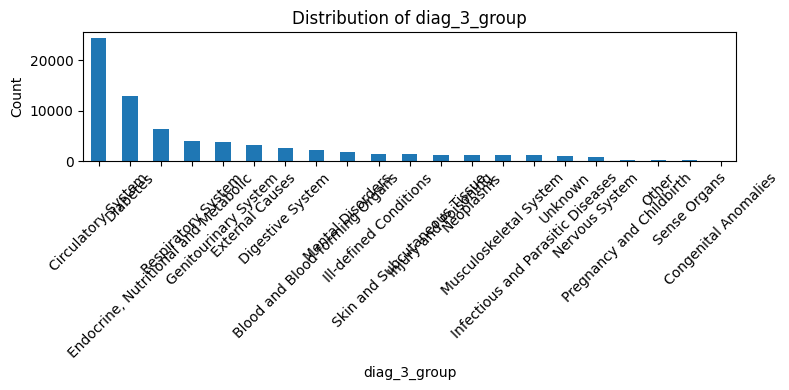

Count  Percentage
diagnosis_tuple                            
('250', '401', '786')       457      0.0064
('250', '401', '715')       374      0.0052
('250', '401', '414')       374      0.0052
('250', '411', '414')       334      0.0047
('250', '410', '414')       262      0.0037
...                         ...         ...
('518', '553', 'V85')         1      0.0000
('276', '571', '574')         1      0.0000
('411', '414', '796')         1      0.0000
('294', '348', 'E939')        1      0.0000
('250.02', '599', '782')      1      0.0000

[35855 rows x 2 columns]

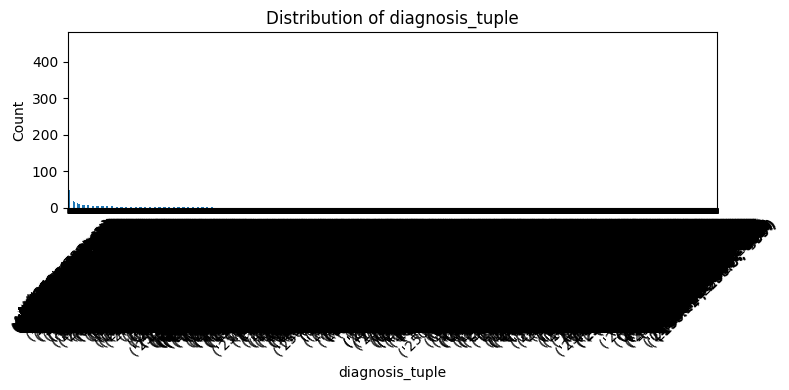

Count  Percentage
uses_secretagogues                   
False               51463      0.7196
True                20055      0.2804

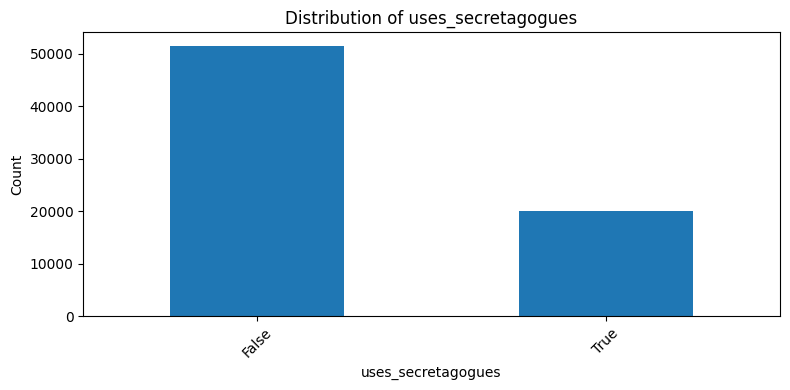

Count  Percentage
uses_sensitizer                   
False            51475      0.7197
True             20043      0.2803

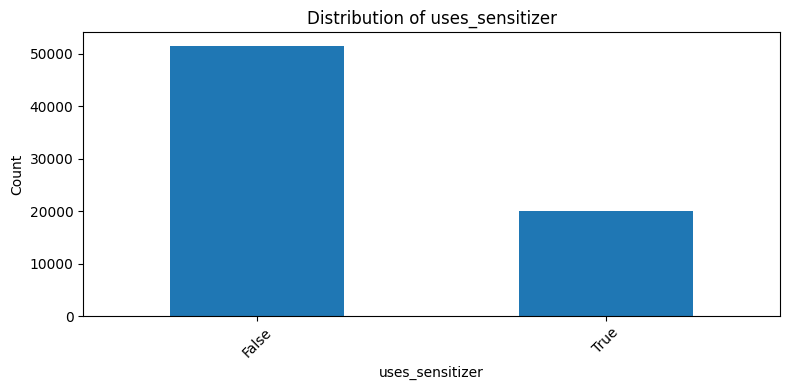

Count  Percentage
uses_insulin_related                   
True                  35908      0.5021
False                 35610      0.4979

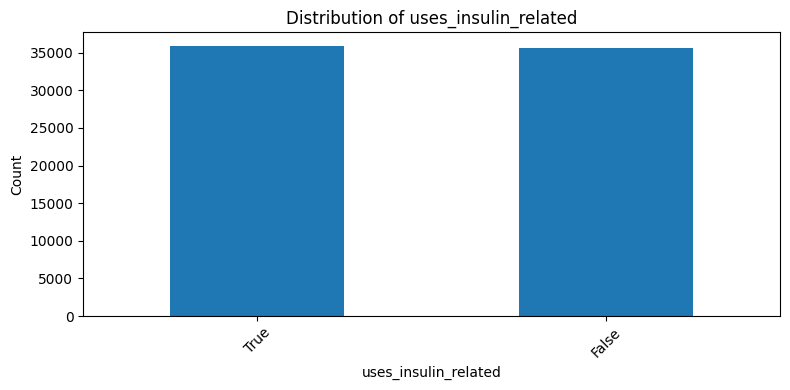

Count  Percentage
uses_alpha_glucosidase_inhibitor                   
False                             71332      0.9974
True                                186      0.0026

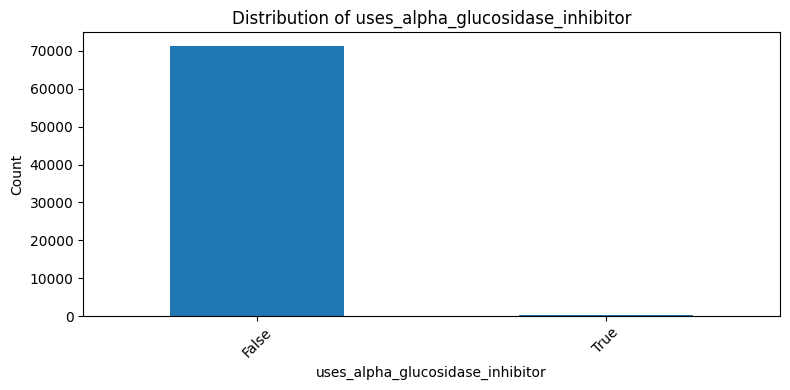

Count  Percentage
uses_other_drugs                   
False             71518         1.0

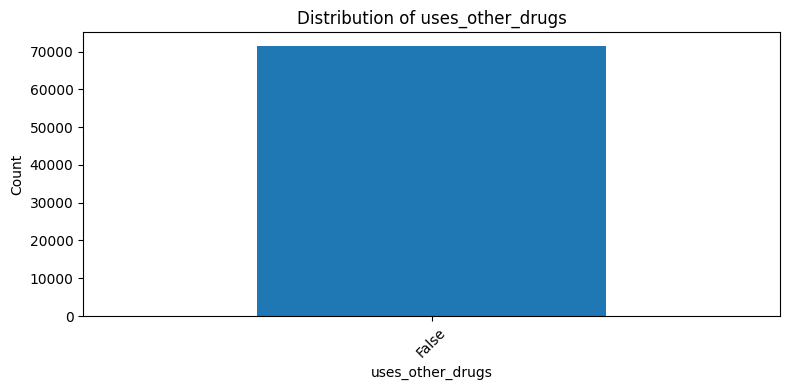

Count  Percentage
has_outpatient                   
0               61731      0.8632
1                9787      0.1368

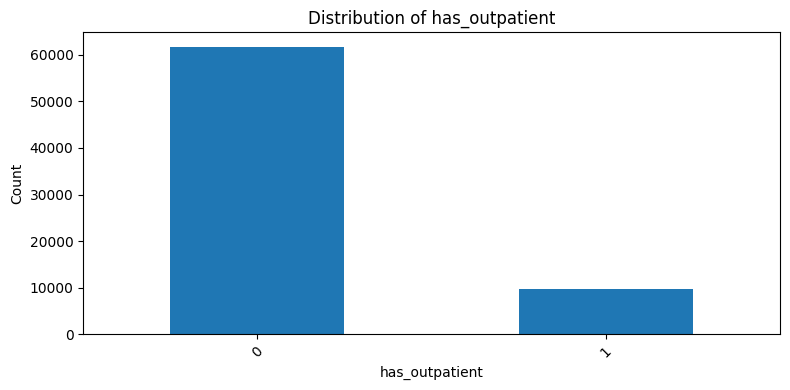

Count  Percentage
has_emergency                   
0              65979      0.9226
1               5539      0.0774

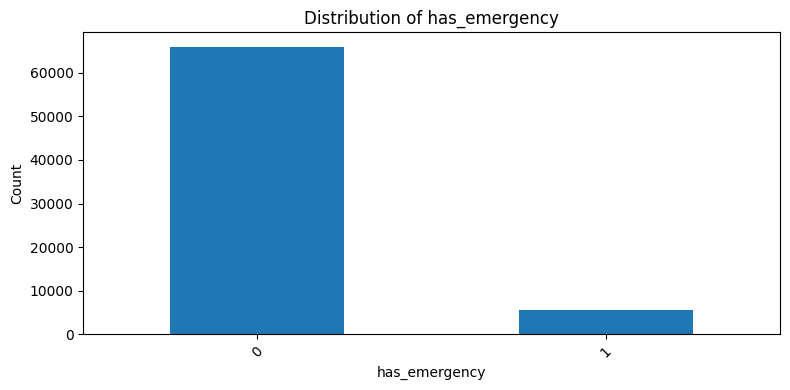

Count  Percentage
has_inpatient                   
0              58705      0.8208
1              12813      0.1792

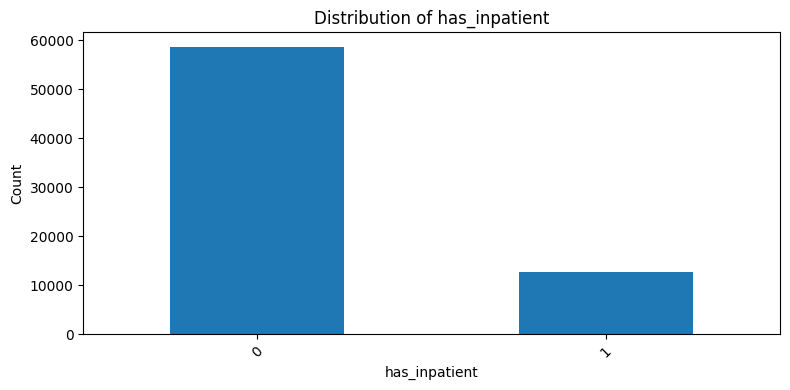

In [77]:
univariate_categorical_analysis(df, categorical_vars)

Categorical Variable Analysis Recommendations

- **`race`**: Imbalanced distribution.  
  → Retain during EDA. After bivariate analysis, consider combining *Hispanic*, *Asian*, and *Other* into a single category.

- **`gender`**: Fairly balanced.  
  → Retain. May consider simplifying to binary classification later.

- **`age`**: Imbalanced.  
  → Consider re-binning into broader age groups or filtering extreme age, e.g. [0, 10) & [80, 100)

- **`payer_code`**: Imbalanced.  
  → Re-categorize into:
    - *Public insurance*
    - *Private insurance*
    - *Self-pay / Uninsured / Other*  
  Then rerun univariate analysis.

- **`max_glu_serum`**: Values like *Norm*, *>200*, *>300* are rare, but medically significant.  
  - *>200* suggests diabetes.  
  - *>300* may indicate serious complications like diabetic ketoacidosis and is linked to higher readmission risk.  
  → Keep original categories, but be cautious of overfitting during modeling.  
  → Create a new auxiliary variable: `measured_glucose = (max_glu_serum != 'Unknown')`.

- **`A1Cresult`**: Same as `max_glu_serum`.  
  → Retain original categories.  
  → Add auxiliary variable: `has_A1C_tested = (A1Cresult != 'Unknown')`.

- **`change`**: Fairly balanced.  
  → Retain. May convert to binary in modeling.

- **`admission_type`**: Retain.  
  → Combine categories like *NULL*, *Not Available*, and *Not Mapped* into `"Unknown"`.

- **`discharge_disposition`**: Retain.  
  → Re-group into major categories like *home*, *transfer*, *expired*, etc. Furthermore, exclude expired for readmission analysis.

- **`admission_source`**: Retain.  
  → Combine categories with <1% frequency into `"Other"`.

- **`specialty_group`**: Retain.  
  → Combine categories with <1% frequency into `"Rare Groups"`.

- **`diag_1_group`**: Retain.  
  → Combine categories with <0.1% frequency into `"Rare Groups"`.

- **`diag_2_group`**: Retain.  
  → Combine categories with <0.5% frequency into `"Rare Groups"`.

- **`diag_3_group`**: Retain.  
  → Combine categories with <0.5% frequency into `"Rare Groups"`.

- **`diagnosis_tuple`**: This variable captures the top-3 ICD codes per patient, sorted as a tuple. However, it contains over **35,000 unique combinations**, and more than **90% of them appear fewer than 5 times**, as shown in the distribution plot.  
  → Define a binary variable such as `rare_diag_tuple = (diagnosis_tuple_freq < 5)` to flag uncommon patterns.

- **`uses_secretagogues`**: Retain.  
- **`uses_sensitizer`**: Retain.  
- **`uses_insulin_related`**: Retain.  

- **`uses_alpha_glucosidase_inhibitor`**: Nearly a single-value variable (99.7%).  
  → Recommend dropping.

- **`uses_other_drugs`**: Single-value variable.  
  → Drop.

- **`has_outpatient`**, **`has_emergency`**, **`has_inpatient`**:  
  → Retain for bivariate analysis.  
  Note: Use the original numeric variables (`number_outpatient`, etc.) during modeling.


Drop columns we've mentioned.

In [78]:
drop_list = ['uses_alpha_glucosidase_inhibitor', 'uses_other_drugs']
df.drop(columns=drop_list, inplace=True)
categorical_vars = [var for var in categorical_vars if var not in drop_list]

Filter extreme age groups.

In [120]:
df['under10_ind'] = (df['age'] == '[0-10)').astype(int)
df['over80_ind']  = df['age'].isin(['[80-90)', '[90-100)']).astype(int)
df = df[(df['under10_ind'] == 0) & (df['over80_ind'] == 0)]
df.drop(columns = ['under10_ind', 'over80_ind'], inplace=True)

Create `rare_diag_tuple`.

In [82]:
df['rare_diag_tuple'] = (df['diagnosis_tuple_freq'] < 5).astype(int)
df.drop(columns = 'diagnosis_tuple', inplace=True)

Next, we reclassify `payer_code` into the following broader categories:

Public insurance

Private insurance

Self-pay / Uninsured / Other

In [117]:
public = ['MC', 'MD']
private = ['BC', 'HM', 'CP', 'CM', 'CH', 'MP', 'SI']
selfpay_other = ['SP', 'UN', 'OG', 'PO', 'DM', 'WC', 'OT']

def map_payer_code(code):
    if code in public:
        return 'Public'
    elif code in private:
        return 'Private'
    elif code in selfpay_other:
        return 'SelfPay/Other'
    else:
        return 'Unknown'


df['payer_group'] = df['payer_code'].apply(map_payer_code)
df.drop(columns = 'payer_code', inplace=True)

categorical_vars.remove('payer_code')
categorical_vars.append('payer_group')


Next, we add auxiliary variables for max_glu_serum and A1Cresult to indicate whether a lab test was performed. These binary indicators help capture the presence or absence of glucose-related lab results, which may be predictive even if the exact test outcome is missing.

In [84]:
df['has_glu_serum_tested'] = df['max_glu_serum'] != 'Unknown'
df['has_A1C_tested'] = df['A1Cresult'] != 'Unknown'

Next, we reclassify the following variables based on the earlier grouping strategies to reduce sparsity and improve model stability:

`admission_type`: Combine "NULL", "Not Available", and "Not Mapped" into "Unknown"

`discharge_disposition`: Re-group into major categories such as "home", "transfer", "expired", etc.

`admission_source`: Combine categories with frequency <1% into "Other"

`specialty_group`: Combine categories with frequency <1% into "Rare Groups"

`diag_1_group`: Combine categories with frequency <0.1% into "Rare Groups"

`diag_2_group` and `diag_3_group`: Combine categories with frequency <0.5% into "Rare Groups"

These transformations simplify the categorical variables and reduce the impact of sparse levels in downstream modeling.

In [85]:
df['admission_type'] = df['admission_type'].replace(
    ['NULL', 'Not Available', 'Not Mapped'],
    'Unknown'
)

In [86]:
def map_discharge_disposition(value):
    value = str(value).lower()

    if 'discharged to home' in value or 'home health service' in value or 'home iv provider' in value:
        return 'Home'
    elif 'snf' in value or 'rehab' in value or 'icf' in value or 'nursing' in value or 'long term care' in value or 'swing bed' in value:
        return 'SNF/Rehab/Nursing'
    elif 'expired' in value:
        return 'Expired'
    elif 'hospice' in value:
        return 'Hospice'
    elif 'another short term hospital' in value or 'another type of inpatient' in value or 'federal' in value or 'psychiatric' in value:
        return 'Other Hospital/Facility'
    elif 'left ama' in value:
        return 'Left AMA'
    elif 'still patient' in value or 'expected to return' in value or 'outpatient services' in value:
        return 'Still Patient/Outpatient'
    elif 'null' in value or 'not mapped' in value or 'not available' in value or 'admitted as an inpatient' in value:
        return 'Unknown'
    else:
        return 'Other'

df['discharge_disposition'] = df['discharge_disposition'].apply(map_discharge_disposition)

Remove patients who expired during the hospital stay. These patients are not eligible for readmission analysis.

In [113]:
df = df[df['discharge_disposition'] != 'Expired']

In [87]:
admission_source_counts = df['admission_source'].value_counts(normalize=True)
rare_sources = admission_source_counts[admission_source_counts < 0.01].index

df['admission_source'] = df['admission_source'].replace(rare_sources, 'Other')

In [88]:
specialty_counts = df['specialty_group'].value_counts(normalize=True)
rare_specialties = specialty_counts[specialty_counts < 0.01].index

df['specialty_group'] = df['specialty_group'].replace(rare_specialties, 'Rare Group')

In [89]:
diag1_counts = df['diag_1_group'].value_counts(normalize=True)
rare_diag1 = diag1_counts[diag1_counts < 0.001].index

df['diag_1_group'] = df['diag_1_group'].replace(rare_diag1, 'Rare Group')

In [90]:
diag2_counts = df['diag_2_group'].value_counts(normalize=True)
rare_diag2 = diag2_counts[diag2_counts < 0.005].index
df['diag_2_group'] = df['diag_2_group'].replace(rare_diag2, 'Rare Group')

diag3_counts = df['diag_3_group'].value_counts(normalize=True)
rare_diag3 = diag3_counts[diag3_counts < 0.005].index
df['diag_3_group'] = df['diag_3_group'].replace(rare_diag3, 'Rare Group')

We then perform univariate analysis again on these reclassified variables to examine their updated distributions.

Count  Percentage
payer_group                     
Unknown        24718      0.4328
Public         16122      0.2823
Private        10405      0.1822
SelfPay/Other   5869      0.1028

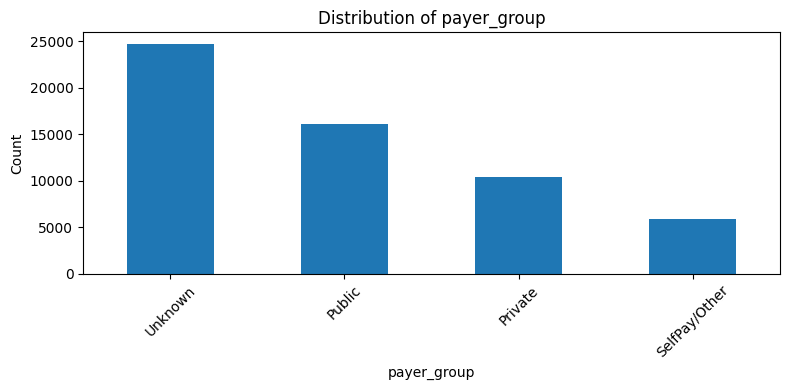

Count  Percentage
has_glu_serum_tested                   
False                 54551      0.9551
True                   2563      0.0449

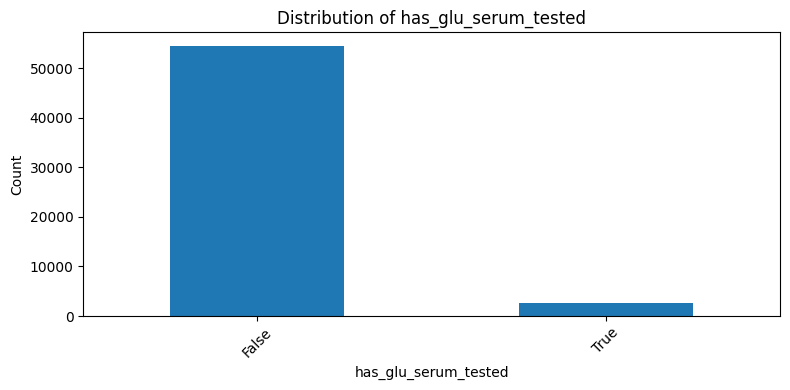

Count  Percentage
has_A1C_tested                   
False           45799      0.8019
True            11315      0.1981

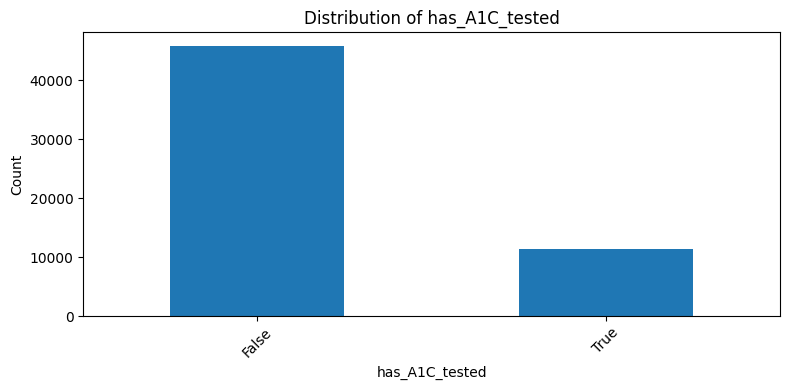

Count  Percentage
admission_type                   
Emergency       28620      0.5011
Elective        12998      0.2276
Urgent           9482      0.1660
Unknown          5995      0.1050
Trauma Center      12      0.0002
Newborn             7      0.0001

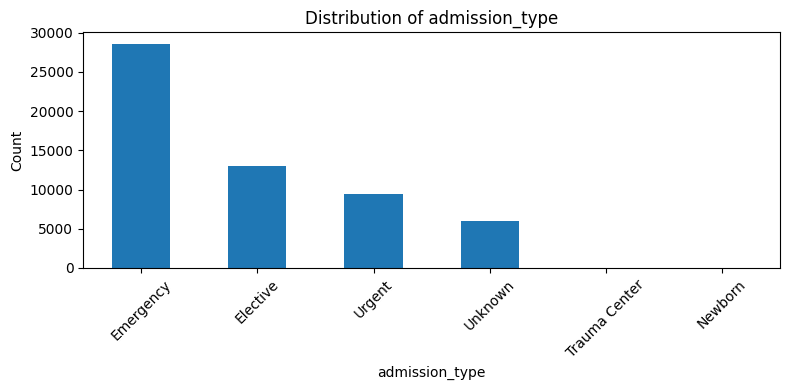

Count  Percentage
discharge_disposition                      
Home                      46175      0.8085
SNF/Rehab/Nursing          6191      0.1084
Unknown                    2446      0.0428
Other Hospital/Facility    1730      0.0303
Left AMA                    310      0.0054
Hospice                     247      0.0043
Still Patient/Outpatient     11      0.0002
Other                         4      0.0001

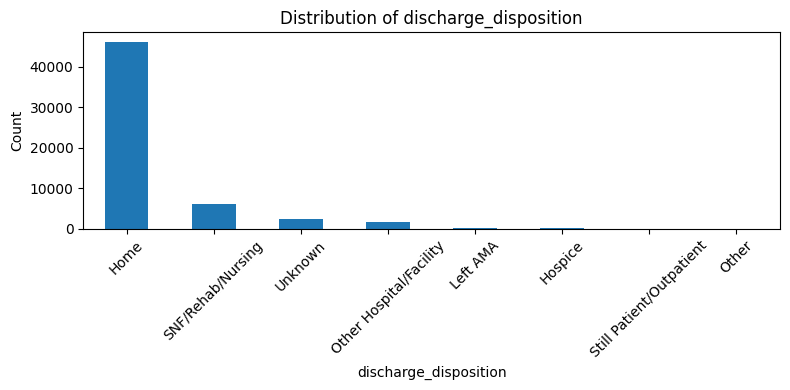

Count  Percentage
admission_source                                             
Emergency Room                              31402      0.5498
Physician Referral                          17222      0.3015
NULL                                         3825      0.0670
Transfer from a hospital                     1941      0.0340
Transfer from another health care facility   1245      0.0218
Clinic Referral                               865      0.0151
Other                                         614      0.0108

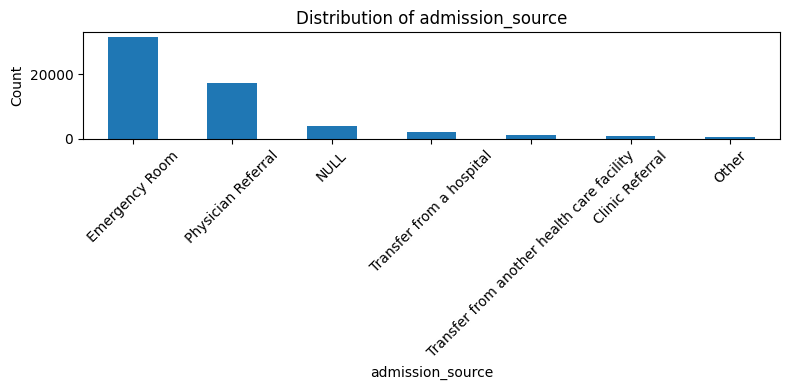

Count  Percentage
specialty_group                    
Other             32901      0.5761
InternalMedicine   8784      0.1538
Cardiology         3880      0.0679
PrimaryCare        3640      0.0637
Surgery            2921      0.0511
Orthopedics        1908      0.0334
Rare Group         1639      0.0287
Nephrology          772      0.0135
OB/GYN              669      0.0117

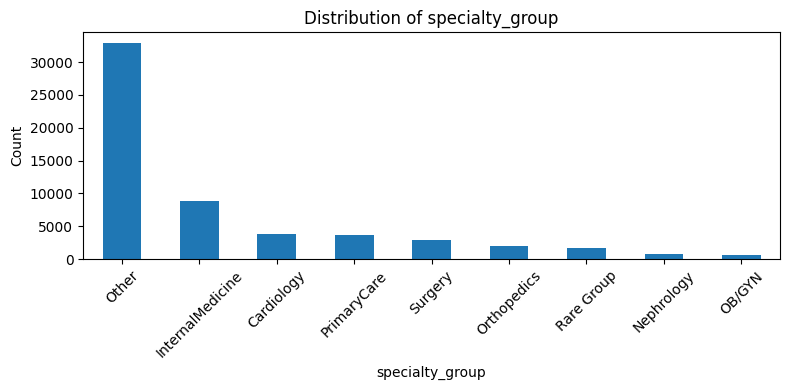

Count  Percentage
diag_1_group                                           
Circulatory System                    18881      0.3306
Respiratory System                     6789      0.1189
Digestive System                       5485      0.0960
Diabetes                               5274      0.0923
Injury and Poisoning                   3404      0.0596
Musculoskeletal System                 3238      0.0567
Genitourinary System                   2543      0.0445
Neoplasms                              2030      0.0355
Endocrine, Nutritional and Metabolic   1405      0.0246
Mental Disorders                       1362      0.0238
Skin and Subcutaneous Tissue           1322      0.0231
Ill-defined Conditions                 1244      0.0218
Infectious and Parasitic Diseases      1211      0.0212
External Causes                         814      0.0143
Blood and Blood-forming Organs          634      0.0111
Pregnancy and Childbirth                580      0.0102
Nervous System                          438      0.0077
Other                                   266      0.0047
Sense Organs                            146      0.0026
Rare Group                               48      0.0008

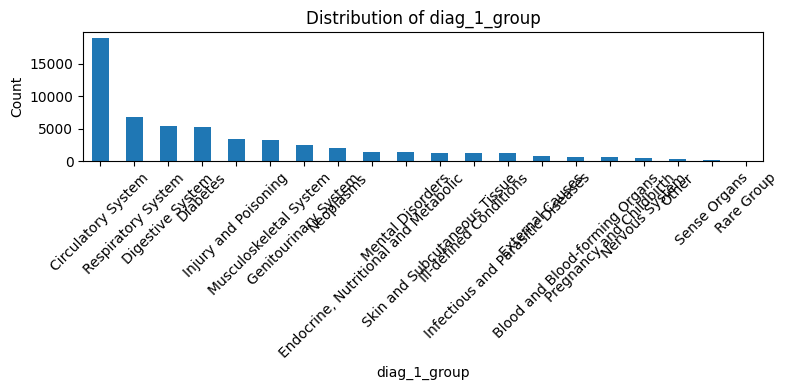

Count  Percentage
diag_2_group                                           
Circulatory System                    19305      0.3380
Diabetes                               8692      0.1522
Respiratory System                     4933      0.0864
Endocrine, Nutritional and Metabolic   4246      0.0743
Genitourinary System                   3754      0.0657
Digestive System                       2428      0.0425
Blood and Blood-forming Organs         1879      0.0329
Skin and Subcutaneous Tissue           1598      0.0280
Mental Disorders                       1550      0.0271
External Causes                        1442      0.0252
Injury and Poisoning                   1361      0.0238
Neoplasms                              1332      0.0233
Ill-defined Conditions                 1246      0.0218
Musculoskeletal System                  993      0.0174
Infectious and Parasitic Diseases       948      0.0166
Nervous System                          529      0.0093
Rare Group                              528      0.0092
Pregnancy and Childbirth                350      0.0061

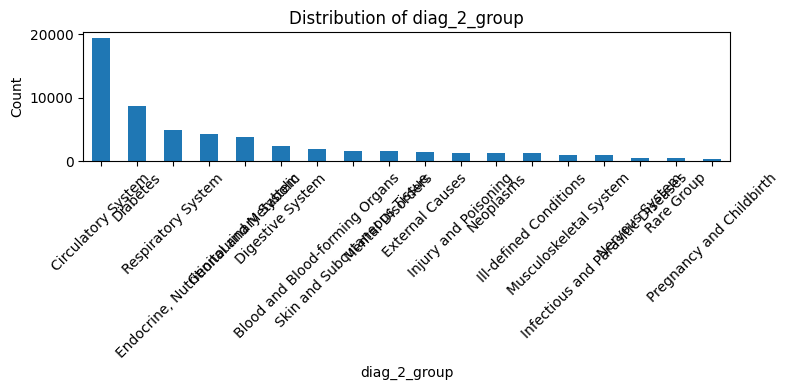

Count  Percentage
diag_3_group                                           
Circulatory System                    18725      0.3279
Diabetes                              10927      0.1913
Endocrine, Nutritional and Metabolic   5065      0.0887
Respiratory System                     3090      0.0541
Genitourinary System                   2795      0.0489
External Causes                        2685      0.0470
Digestive System                       2254      0.0395
Mental Disorders                       1663      0.0291
Blood and Blood-forming Organs         1628      0.0285
Ill-defined Conditions                 1156      0.0202
Skin and Subcutaneous Tissue           1066      0.0187
Injury and Poisoning                   1012      0.0177
Musculoskeletal System                  997      0.0175
Unknown                                 932      0.0163
Infectious and Parasitic Diseases       920      0.0161
Neoplasms                               920      0.0161
Nervous System                          669      0.0117
Rare Group                              610      0.0107

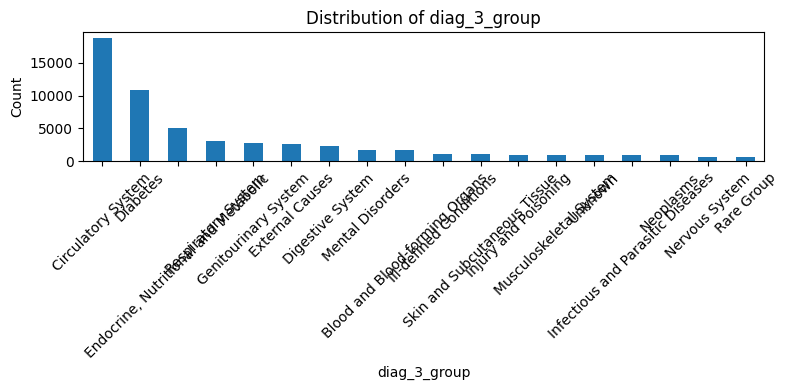

In [114]:
univariate_categorical_analysis(df, ['payer_group','has_glu_serum_tested', 'has_A1C_tested', 'admission_type',
                                     'discharge_disposition', 'admission_source', 'specialty_group', 'diag_1_group',
                                     'diag_2_group', 'diag_3_group'])

The reclassified variables now exhibit clearer and more balanced distributions, making them more suitable for subsequent analysis.

## Bivariate Analysis  
We examine the relationships between each feature and the target variable `readmit_level` using appropriate **statistical tests** (e.g., **Kruskal-Wallis** for numerical variables, **Chi-squared** for categorical variables), along with **visualizations** to support interpretation.


The first step of bivariate analysis involves testing associations between each variable (categorical or numerical) and the target `readmit_level`.
We focus on determining which variables show statistically significant relationships, as these are likely to be valuable for predictive modeling.

In [92]:
target_var = 'readmit_level'

In [121]:
print(df.dtypes)

patient_nbr                int64
time_in_hospital           int64
num_lab_procedures         int64
num_procedures             int64
num_medications            int64
number_outpatient          int64
number_emergency           int64
number_inpatient           int64
number_diagnoses           int64
diagnosis_tuple_freq       int64
race                      object
gender                    object
age                       object
max_glu_serum             object
A1Cresult                 object
change                    object
diabetesMed               object
admission_type            object
discharge_disposition     object
admission_source          object
specialty_group           object
diag_1_group              object
diag_2_group              object
diag_3_group              object
readmit_level             object
total_hospital_days        int64
total_labs                 int64
total_meds                 int64
uses_secretagogues          bool
uses_sensitizer             bool
uses_insul

In [122]:
categorical_vars = df.select_dtypes(include=['object','bool']).columns.tolist()
numeric_vars = df.select_dtypes(include=['int64','float64']).columns.tolist()
for col in ['patient_nbr', 'readmit_level','has_outpatient', 'has_emergency', 'has_inpatient']:
    if col in numeric_vars:
        numeric_vars.remove(col)
for col in ['has_outpatient', 'has_emergency', 'has_inpatient']:
  categorical_vars.append(col)

**Categorical variables vs `readmit_level`**

In [123]:
from scipy.stats import chi2_contingency

def analyze_cat_vs_target(data, cat_vars, target_var):
    for var in cat_vars:
        print(f"\n=== {var} vs {target_var} ===")
        ct = pd.crosstab(data[var], data[target_var])
        print(ct)

        chi2, p, dof, expected = chi2_contingency(ct)
        print(f"Chi2 = {chi2:.2f}, p-value = {p:.4f}")

In [124]:
analyze_cat_vs_target(df, categorical_vars, target_var)


=== race vs readmit_level ===
readmit_level        0      1
race                         
AfricanAmerican   9085   2239
Asian              341     79
Caucasian        31127  10362
Hispanic          1088    297
Other              791    221
Unknown           1228    256
Chi2 = 179.56, p-value = 0.0000

=== gender vs readmit_level ===
readmit_level        0     1
gender                      
Female           22179  6993
Male             21478  6461
Unknown/Invalid      3     0
Chi2 = 6.60, p-value = 0.0369

=== age vs readmit_level ===
readmit_level      0     1
age                       
[10-20)          433   100
[20-30)          909   203
[30-40)         2178   506
[40-50)         5397  1401
[50-60)         9638  2720
[60-70)        11909  3842
[70-80)        13196  4682
Chi2 = 181.24, p-value = 0.0000

=== max_glu_serum vs readmit_level ===
readmit_level      0      1
max_glu_serum              
>200             614    180
>300             421    141
Norm             973    234
Unkn

Based on the results of the Chi-squared tests, we find that the p-values for all categorical variables are less than 0.05.

Therefore, we reject the null hypothesis (H₀) and conclude that all these categorical variables have a statistically significant association with the target variable `readmit_level`.

**Numeric vairables vs `readmit_level`**

In [125]:
from scipy.stats import f_oneway, kruskal, shapiro, levene

def analyze_num_vs_target(data, num_vars, target_var):
    for var in num_vars:
        print(f"\n=== {var} vs {target_var} ===")
        groups = [group[var].dropna() for _, group in data.groupby(target_var)]

        # Check for normality and homogeneity of variance
        for i, g in enumerate(groups):
            if len(g) >= 3:
                stat, p = shapiro(g.sample(min(5000, len(g))))
                print(f"  Group {i}: Shapiro p = {p:.4f}")

        stat, p_levene = levene(*groups)
        print(f"  Levene’s Test p = {p_levene:.4f}")

        # Significance test
        if all(shapiro(g.sample(min(5000, len(g))))[1] > 0.05 for g in groups):
            stat, p = f_oneway(*groups)
            print(f"ANOVA p = {p:.4f}")
        else:
            stat, p = kruskal(*groups)
            print(f"Kruskal-Wallis p = {p:.4f}")

        # Boxplot
        sns.boxplot(data=data, x=target_var, y=var)
        plt.title(f'{var} vs {target_var}')
        plt.show()

        # Violin plot
        sns.violinplot(data=data, x=target_var, y=var)
        plt.title(f'{var} vs {target_var}')
        plt.show()


=== time_in_hospital vs readmit_level ===
  Group 0: Shapiro p = 0.0000
  Group 1: Shapiro p = 0.0000
  Levene’s Test p = 0.0006
Kruskal-Wallis p = 0.0000


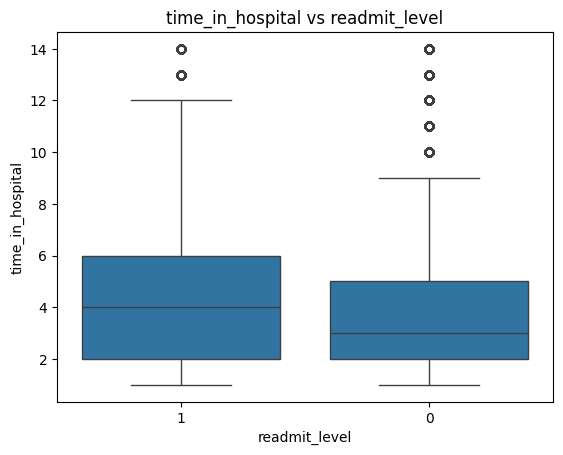

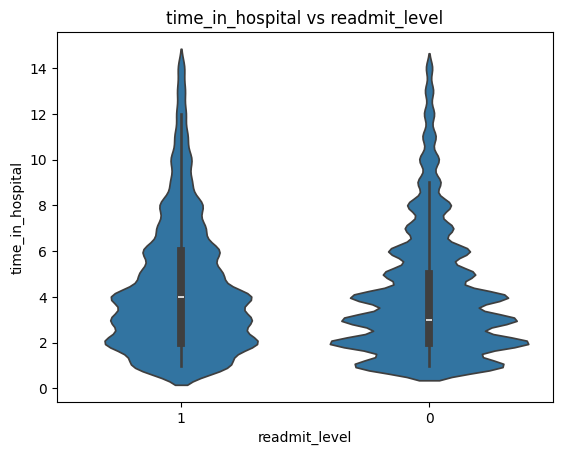


=== num_lab_procedures vs readmit_level ===
  Group 0: Shapiro p = 0.0000
  Group 1: Shapiro p = 0.0000
  Levene’s Test p = 0.1346
Kruskal-Wallis p = 0.0000


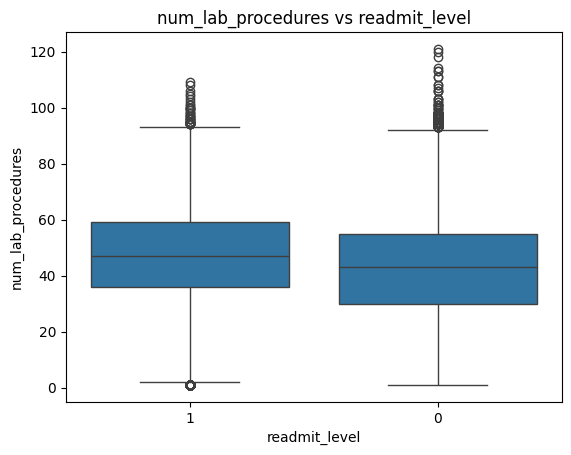

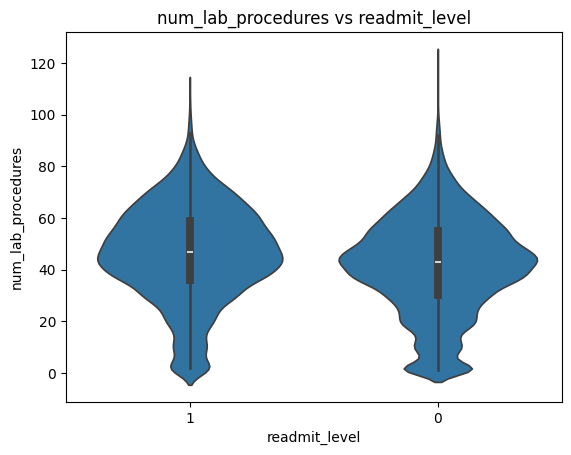


=== num_procedures vs readmit_level ===
  Group 0: Shapiro p = 0.0000
  Group 1: Shapiro p = 0.0000
  Levene’s Test p = 0.0158
Kruskal-Wallis p = 0.0000


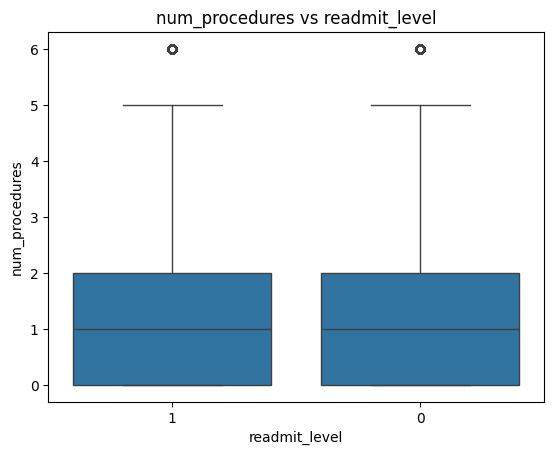

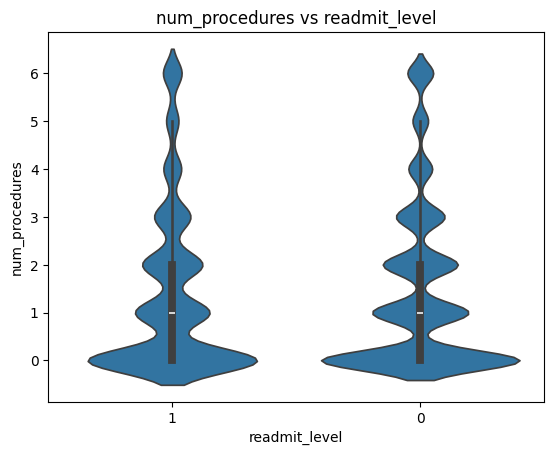


=== num_medications vs readmit_level ===
  Group 0: Shapiro p = 0.0000
  Group 1: Shapiro p = 0.0000
  Levene’s Test p = 0.0000
Kruskal-Wallis p = 0.0000


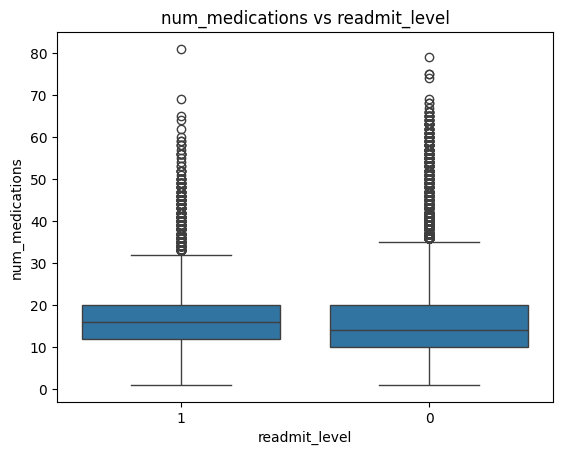

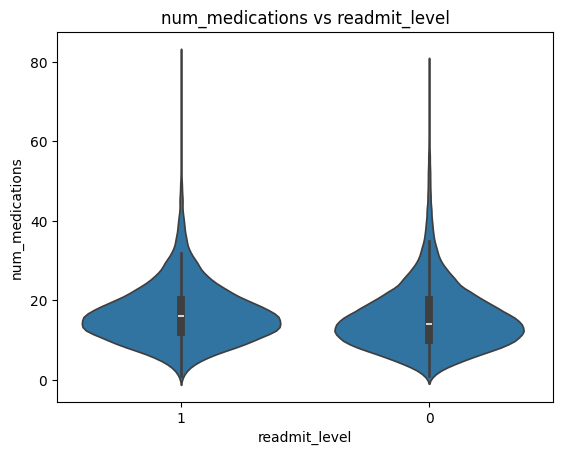


=== number_outpatient vs readmit_level ===
  Group 0: Shapiro p = 0.0000
  Group 1: Shapiro p = 0.0000
  Levene’s Test p = 0.0000
Kruskal-Wallis p = 0.0000


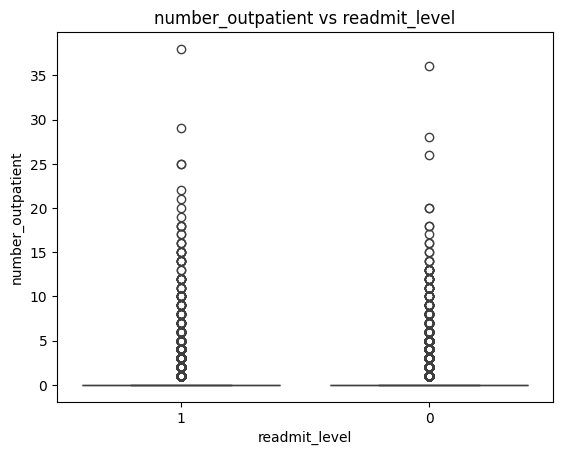

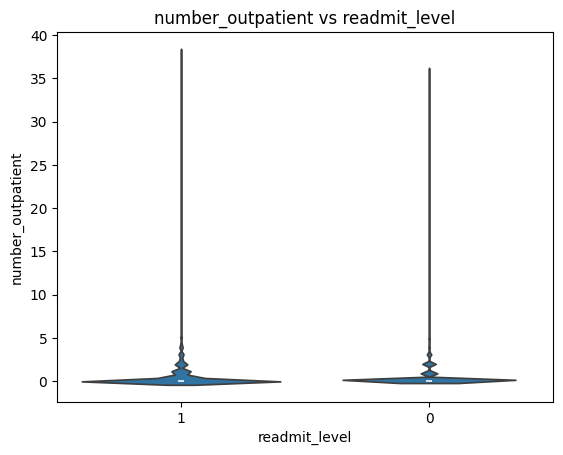


=== number_emergency vs readmit_level ===
  Group 0: Shapiro p = 0.0000
  Group 1: Shapiro p = 0.0000
  Levene’s Test p = 0.0000
Kruskal-Wallis p = 0.0000


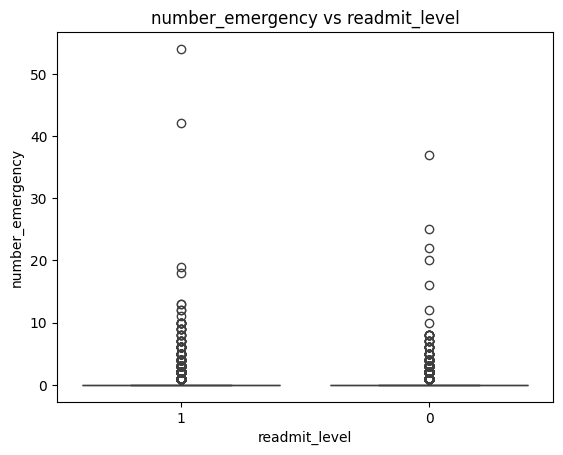

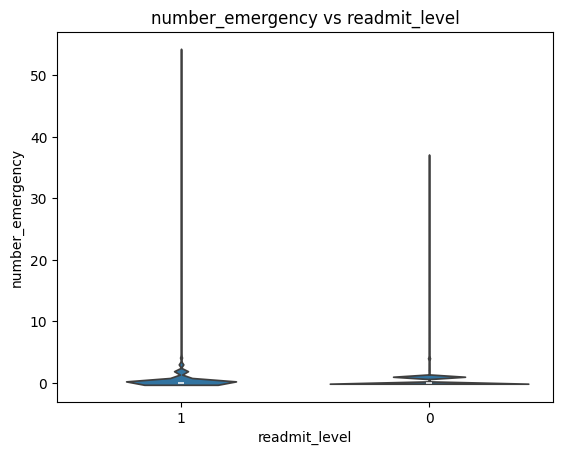


=== number_inpatient vs readmit_level ===
  Group 0: Shapiro p = 0.0000
  Group 1: Shapiro p = 0.0000
  Levene’s Test p = 0.0000
Kruskal-Wallis p = 0.0000


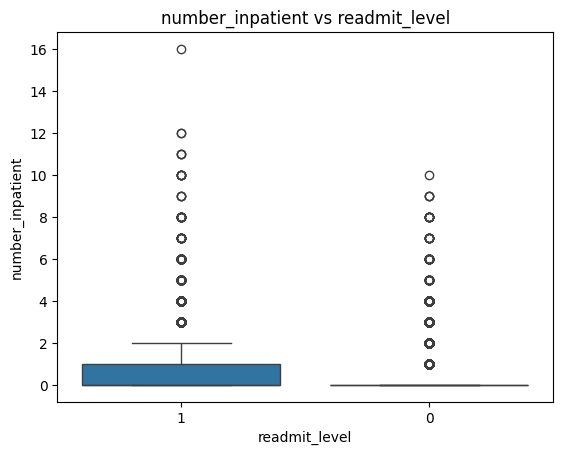

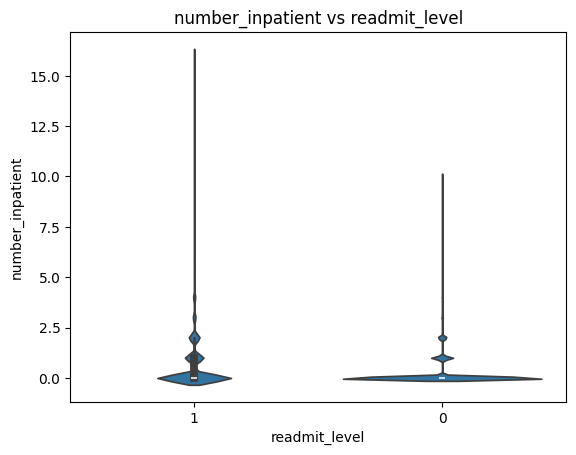


=== number_diagnoses vs readmit_level ===
  Group 0: Shapiro p = 0.0000
  Group 1: Shapiro p = 0.0000
  Levene’s Test p = 0.0000
Kruskal-Wallis p = 0.0000


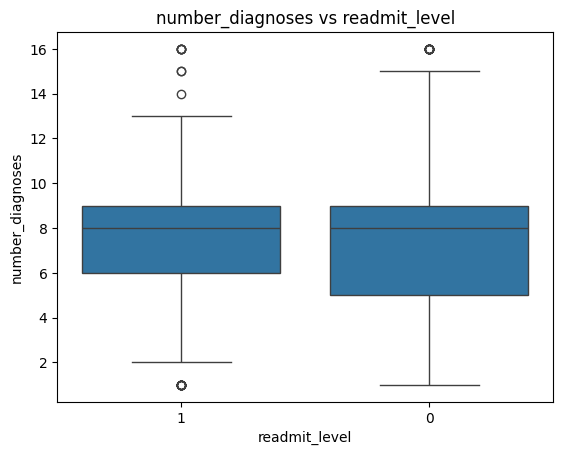

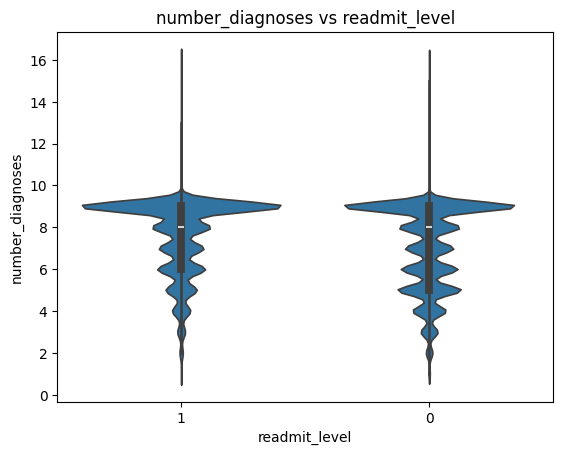


=== diagnosis_tuple_freq vs readmit_level ===
  Group 0: Shapiro p = 0.0000
  Group 1: Shapiro p = 0.0000
  Levene’s Test p = 0.0000
Kruskal-Wallis p = 0.3647


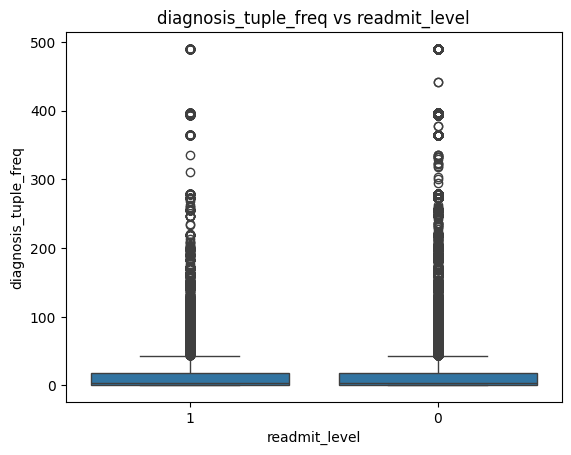

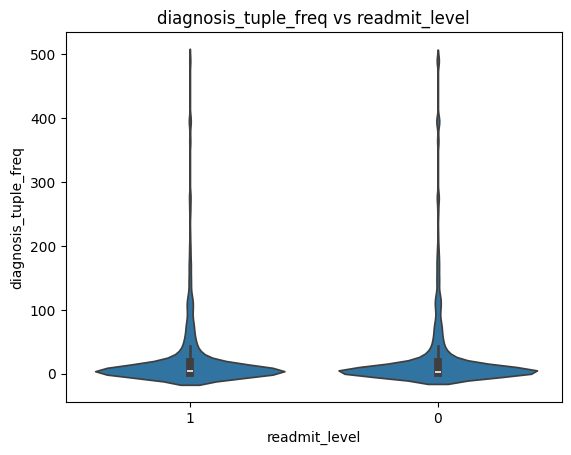


=== total_hospital_days vs readmit_level ===
  Group 0: Shapiro p = 0.0000
  Group 1: Shapiro p = 0.0000
  Levene’s Test p = 0.0000
Kruskal-Wallis p = 0.0000


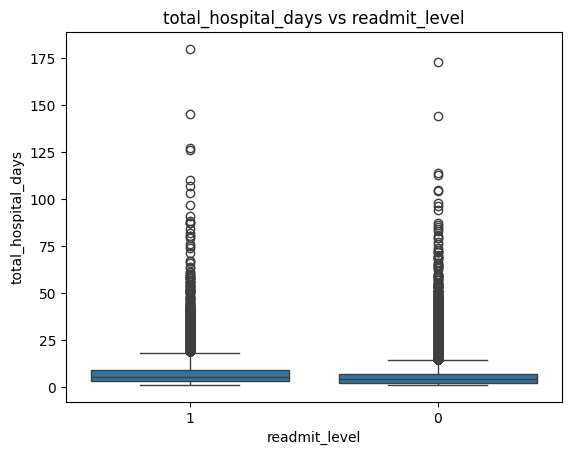

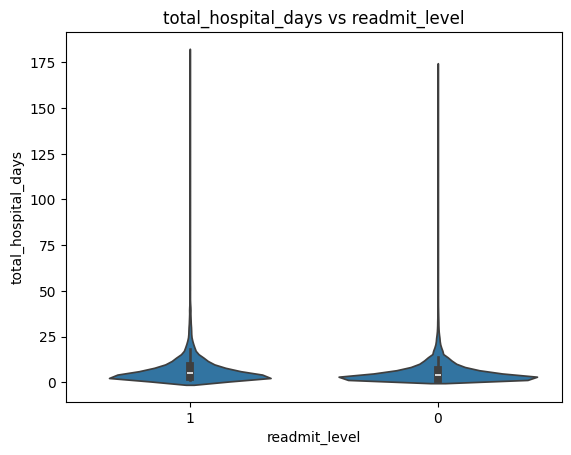


=== total_labs vs readmit_level ===
  Group 0: Shapiro p = 0.0000
  Group 1: Shapiro p = 0.0000
  Levene’s Test p = 0.0000
Kruskal-Wallis p = 0.0000


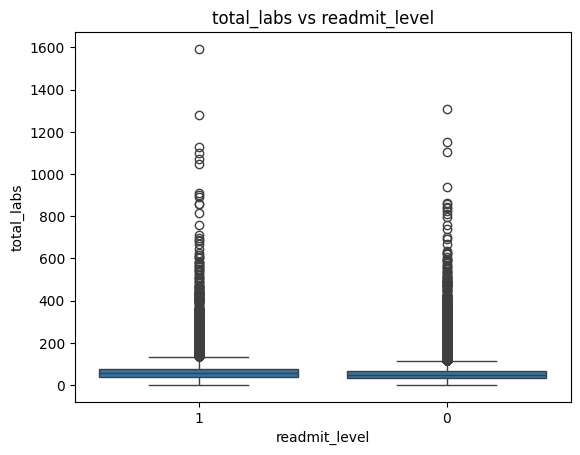

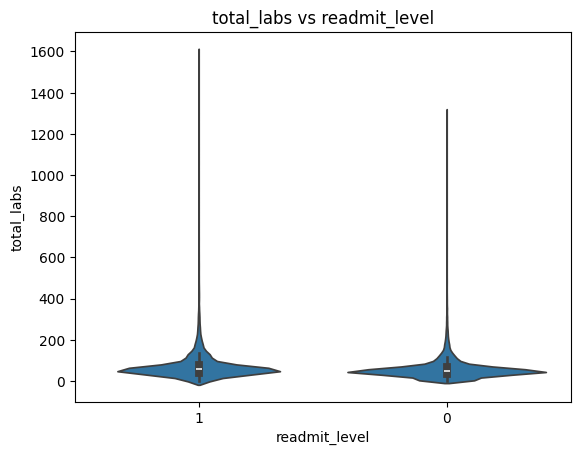


=== total_meds vs readmit_level ===
  Group 0: Shapiro p = 0.0000
  Group 1: Shapiro p = 0.0000
  Levene’s Test p = 0.0000
Kruskal-Wallis p = 0.0000


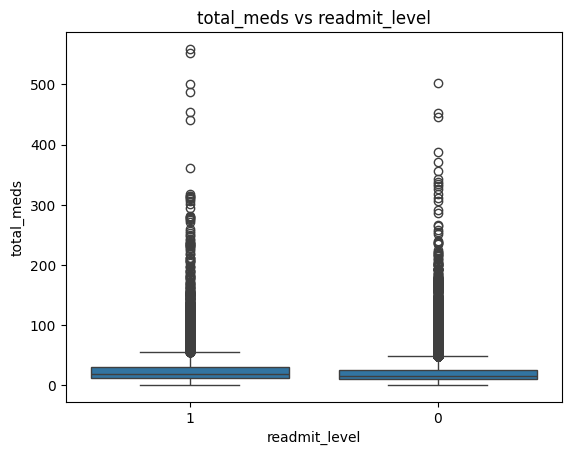

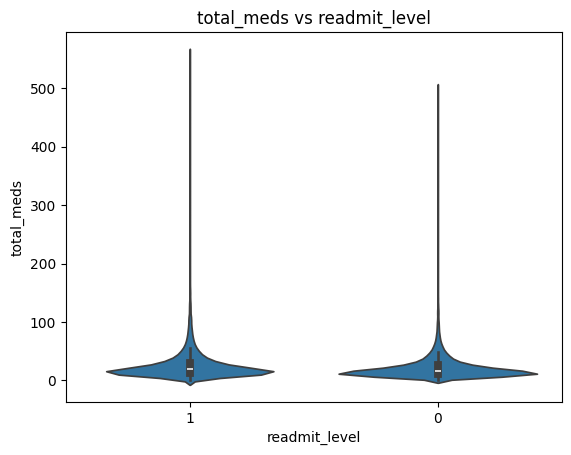


=== rare_diag_tuple vs readmit_level ===
  Group 0: Shapiro p = 0.0000
  Group 1: Shapiro p = 0.0000
  Levene’s Test p = 0.5016
Kruskal-Wallis p = 0.5016


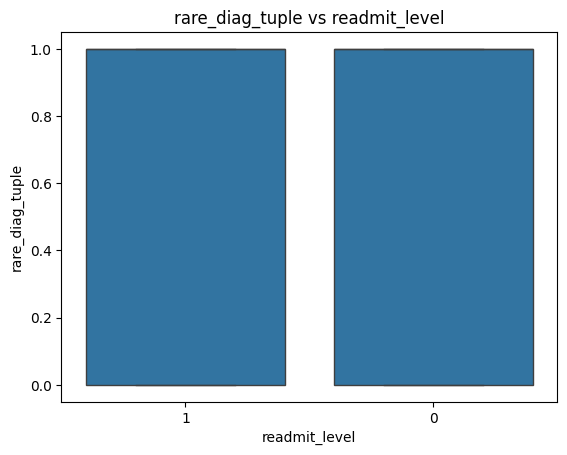

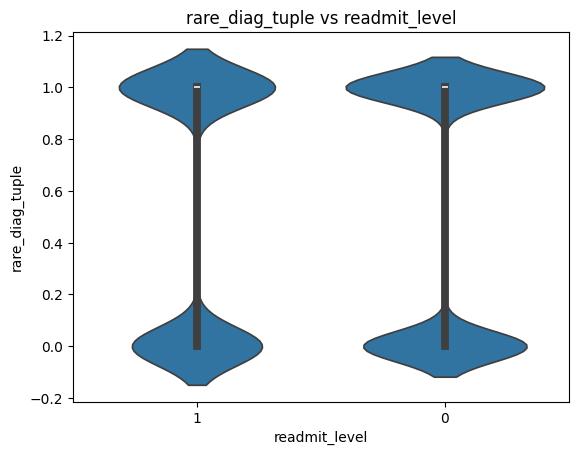


=== total_burden_score vs readmit_level ===
  Group 0: Shapiro p = 0.0000
  Group 1: Shapiro p = 0.0000
  Levene’s Test p = 0.0000
Kruskal-Wallis p = 0.0000


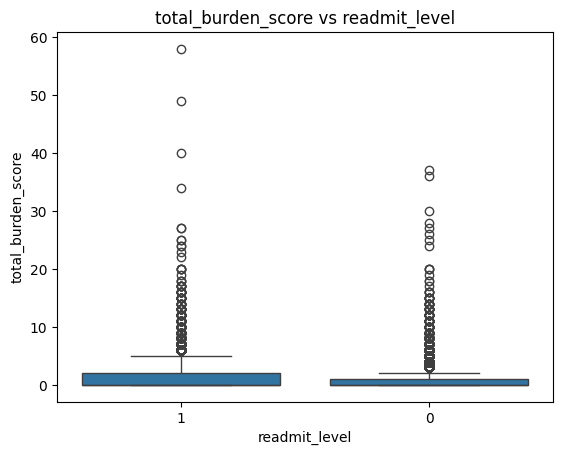

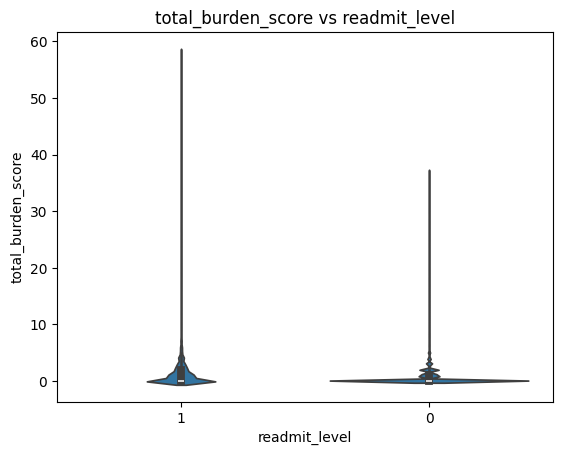


=== meds_per_day vs readmit_level ===
  Group 0: Shapiro p = 0.0000
  Group 1: Shapiro p = 0.0000
  Levene’s Test p = 0.0010
Kruskal-Wallis p = 0.0000


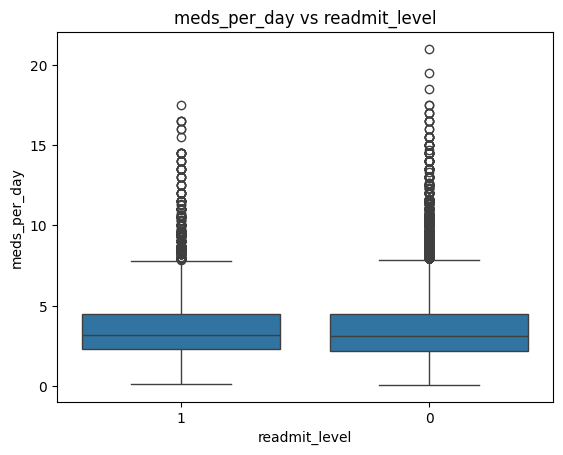

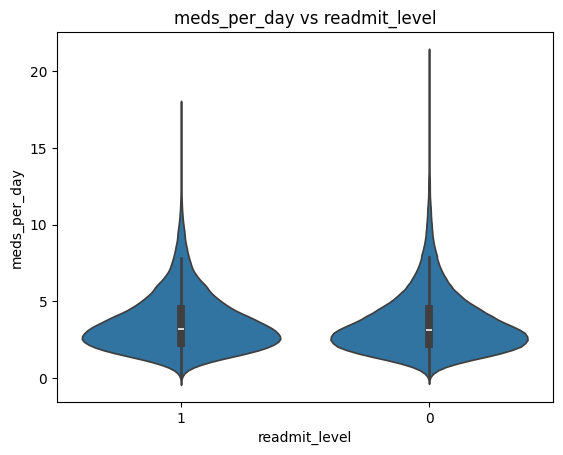


=== is_public_high_burden vs readmit_level ===
  Group 0: Shapiro p = 0.0000
  Group 1: Shapiro p = 0.0000
  Levene’s Test p = 0.0000
Kruskal-Wallis p = 0.0000


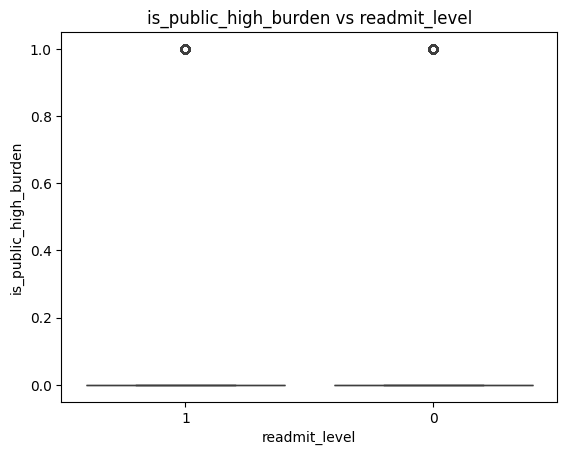

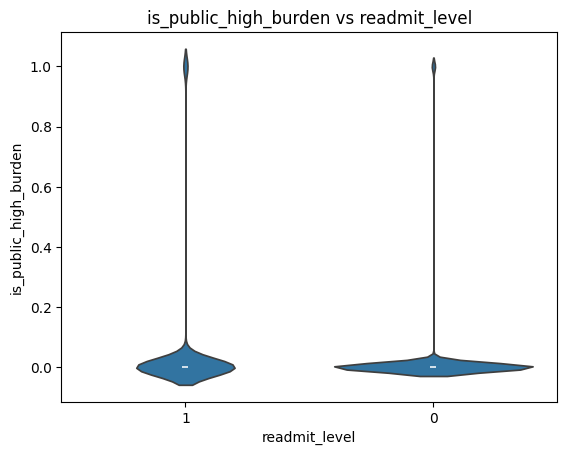

In [126]:
analyze_num_vs_target(df, numeric_vars, target_var)

Since the Shapiro-Wilk test indicated that the variable is not normally distributed within any of the readmit_level groups (p < 0.05), we conducted a Kruskal-Wallis test to assess differences across groups. According to the test results, nearly all p-values are below 0.05, indicating that these variables are statistically associated with the target variable `readmit_level`, except `diagnosis_tuple_freq` and `rare_diag_tuple`. Both `rare_diag_tuple` and `diagnosis_tuple_freq` show no significant differences across readmission levels, suggesting limited standalone predictive power, though `diagnosis_tuple_freq` may still hold value in interaction with other features. Therefore, these features may have limited discriminative power alone, but could still contribute in interaction with other variables.


Variables such as `num_medications` and `num_lab_procedures` show a clear increasing trend in their distributions from non-readmitted to readmitted patients. This suggests that patients receiving more medications or undergoing more lab procedures are more likely to be readmitted, likely reflecting higher care complexity or disease severity.

Both `time_in_hospital` and `number_diagnoses` exhibit relatively balanced distributions across outcome groups, with only slight differences in central tendency or spread. While these variables are not strong differentiators on their own, they still offer clinical interpretability and may contribute modest predictive value when used in combination with other features.

The variables `number_outpatient`, `number_emergency`, and `number_inpatient` are highly right-skewed. Most patients have zero visits, while a small subset contributes disproportionately high values. Binary transformation (e.g., converting to indicators for “≥1 prior visit”) may be more effective than retaining raw counts in modeling, especially for tree-based methods that are sensitive to skewed distributions.

Lastly, `num_procedures` displays very similar distributions across `readmit_level` groups, with a large proportion of zeros and overlapping interquartile ranges. Its limited variability and discriminatory power suggest that it may not contribute meaningfully to prediction and could be a candidate for exclusion unless retained for clinical completeness.

Based on domain knowledge, we further examine the following feature–feature relationships to assess potential redundancy or strong correlation among variables:

`num_medications` vs `number_diagnoses`

`num_medications` vs `time_in_hospital`

`number_diagnoses` vs `time_in_hospital`

`num_lab_procedures` vs `number_diagnoses`

`num_lab_procedures` vs `num_medications`

These comparisons help identify overlapping information that may lead to multicollinearity or unnecessary complexity in modeling.

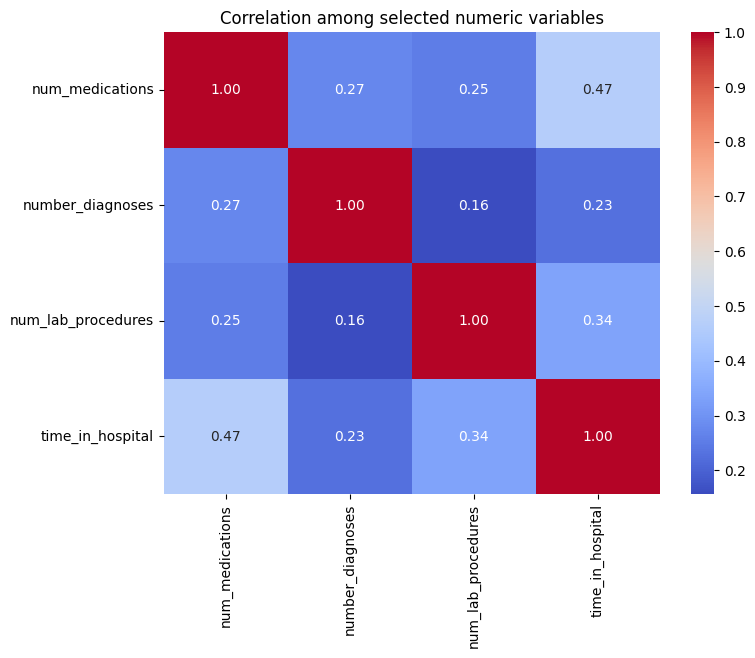

In [99]:
selected_vars = ['num_medications', 'number_diagnoses', 'num_lab_procedures', 'time_in_hospital']
corr = df[selected_vars].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation among selected numeric variables")
plt.show()

Since all pairwise correlations are **below** the commonly used threshold of **0.8**, we conclude that there is no substantial redundancy among these features. All can be retained for modeling.

Additionally, we examine the following pairs of categorical variables to assess potential redundancy or dependency between them:

`admission_type` vs `admission_source`

`discharge_disposition` vs `admission_source`

`admission_type` vs `discharge_disposition`

`specialty_group` vs `admission_type`

`specialty_group` vs `admission_source`

`specialty_group` vs `discharge_disposition`

These analyses help evaluate whether some variables may encode overlapping information and guide feature selection or consolidation if needed.

In [100]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2, _, _, _ = chi2_contingency(confusion_matrix)
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    return np.sqrt(phi2 / min(k-1, r-1))

pairs = [
    ('admission_type', 'admission_source'),
    ('discharge_disposition', 'admission_source'),
    ('admission_type', 'discharge_disposition'),
    ('specialty_group', 'admission_type'),
    ('specialty_group', 'admission_source'),
    ('specialty_group', 'discharge_disposition'),
]

print("Cramér's V for selected categorical variable pairs:\n")
for var1, var2 in pairs:
    v = cramers_v(df[var1], df[var2])
    print(f"{var1} vs {var2}: Cramér's V = {v:.4f}")

Cramér's V for selected categorical variable pairs:

admission_type vs admission_source: Cramér's V = 0.4606
discharge_disposition vs admission_source: Cramér's V = 0.0682
admission_type vs discharge_disposition: Cramér's V = 0.0494
specialty_group vs admission_type: Cramér's V = 0.1689
specialty_group vs admission_source: Cramér's V = 0.1796
specialty_group vs discharge_disposition: Cramér's V = 0.0640


Here, we observe a strong association between `admission_type` and `admission_source`, suggesting potential redundancy between these two variables.

If using tree-based models, both variables can be retained, as they can handle correlated features effectively.

However, if using regression-based models, we recommend keeping only `admission_type` to avoid multicollinearity issues.

We then explore the following relationships between payer_group and selected numerical variables, to investigate potential differences in healthcare utilization across insurance types:

`payer_group` vs `num_medications`

`payer_group` vs `time_in_hospital`

These comparisons may reveal whether payer type influences the intensity of treatment or length of hospital stay.

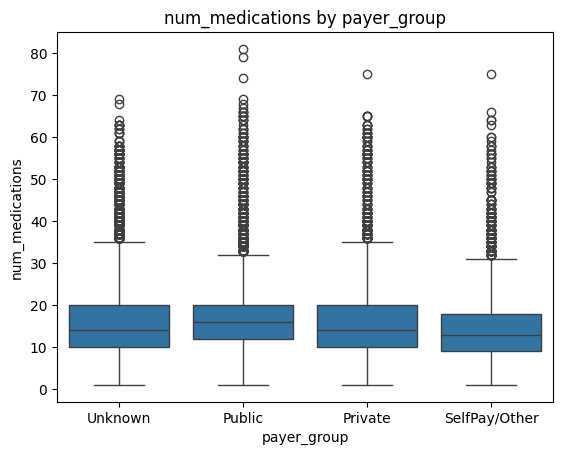

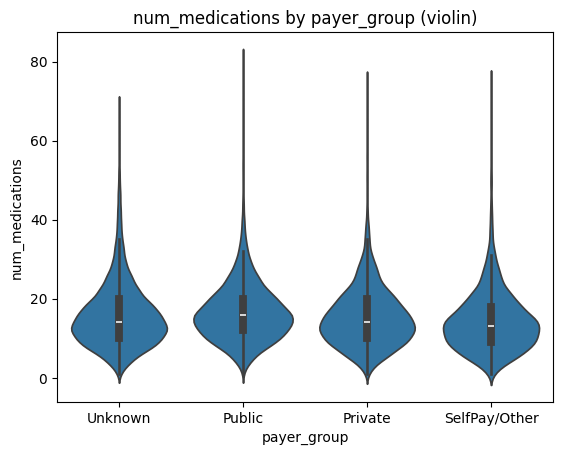

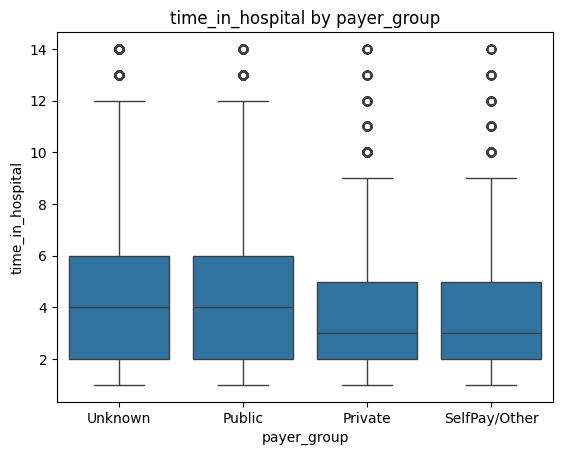

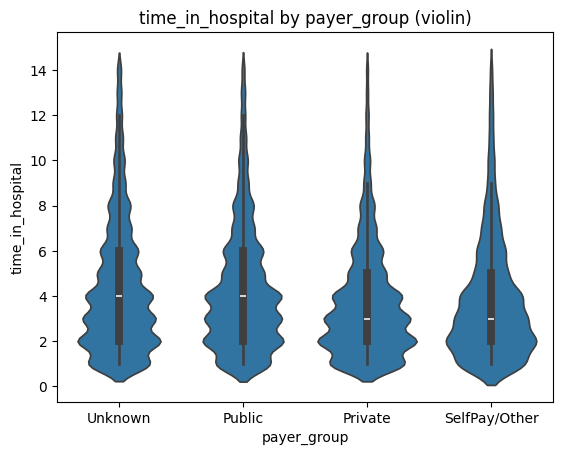

num_medications vs payer_group: Kruskal-Wallis p = 0.0000
time_in_hospital vs payer_group: Kruskal-Wallis p = 0.0000


In [101]:
for var in ['num_medications', 'time_in_hospital']:
    sns.boxplot(data=df, x='payer_group', y=var)
    plt.title(f"{var} by payer_group")
    plt.show()

    sns.violinplot(data=df, x='payer_group', y=var)
    plt.title(f"{var} by payer_group (violin)")
    plt.show()

for var in ['num_medications', 'time_in_hospital']:
    groups = [g[var].dropna() for _, g in df.groupby('payer_group')]
    stat, p = kruskal(*groups)
    print(f"{var} vs payer_group: Kruskal-Wallis p = {p:.4f}")

Patients in the Public insurance group tend to have a slightly higher number of medications, while those in the SelfPay/Other group have lower medication counts.
The difference is statistically significant (p < 0.001).

Patients in the Public and Unknown insurance groups tend to have slightly longer hospital stays, while those in the Private and SelfPay groups have shorter stays.
The difference is statistically significant (p < 0.001).

## Feature Engineering

We constructed three new features to enhance the predictive power of the dataset:

- **`total_burden_score`**: Reflects the overall healthcare utilization burden for each patient.
- **`meds_per_day`**: Represents the average number of medications per day during hospitalization, serving as a proxy for illness severity.
- **`is_public_high_burden`**: Flags high-risk patients who are publicly insured and have a heavy medical burden (e.g., frequent admissions), potentially reflecting socioeconomic vulnerability.

We also conducted statistical tests to assess the significance of their associations with the target variable `readmit_level`.

In [102]:
df['total_burden_score'] = (
    df['number_inpatient'].fillna(0) +
    df['number_emergency'].fillna(0) +
    df['number_outpatient'].fillna(0)
)

In [103]:
df['readmit_level'] = df['readmit_level'].astype(str)

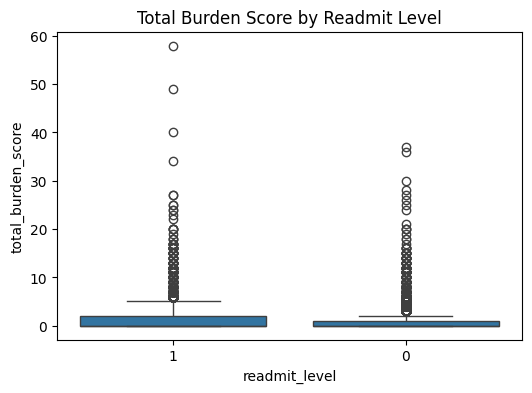

Kruskal-Wallis test for total_burden_score:
Statistic = 2876.01, p-value = 0.0000e+00


In [104]:
plt.figure(figsize=(6,4))
sns.boxplot(x='readmit_level', y='total_burden_score', data=df)
plt.title('Total Burden Score by Readmit Level')
plt.show()

kw_result = kruskal(*[df[df['readmit_level'] == level]['total_burden_score'] for level in df['readmit_level'].unique()])
print(f"Kruskal-Wallis test for total_burden_score:\nStatistic = {kw_result.statistic:.2f}, p-value = {kw_result.pvalue:.4e}")

`total_burden_score` shows a statistically significant difference across `readmit_level` groups (p < 0.001), with readmitted patients having notably higher burden scores on average. This pattern suggests that increased cumulative medical burden is associated with higher readmission risk. Therefore, this variable is retained for further modeling as an indicator of patient complexity and care intensity.

In [105]:
df['meds_per_day'] = df['num_medications'] / (df['time_in_hospital'] + 1)

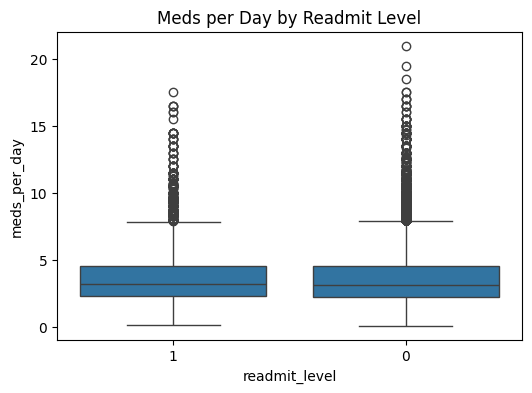

Kruskal-Wallis test for meds_per_day:
Statistic = 16.59, p-value = 4.6380e-05


In [106]:
plt.figure(figsize=(6,4))
sns.boxplot(x='readmit_level', y='meds_per_day', data=df)
plt.title('Meds per Day by Readmit Level')
plt.show()

kw_result = kruskal(*[df[df['readmit_level'] == level]['meds_per_day'] for level in df['readmit_level'].unique()])
print(f"Kruskal-Wallis test for meds_per_day:\nStatistic = {kw_result.statistic:.2f}, p-value = {kw_result.pvalue:.4e}")

`meds_per_day` shows a statistically significant difference across readmit_level groups (p < 0.001),
though the distributional differences are relatively subtle.
Given its theoretical relevance, we will temporarily retain this feature for further evaluation.

In [107]:
numeric_vars.append('total_burden_score')
numeric_vars.append('meds_per_day')
categorical_vars.append('is_public_high_burden')

In [108]:
df['is_public_high_burden'] = (
    ((df['payer_group'] == 'Public') & (df['number_inpatient'] > 1))
).astype(int)

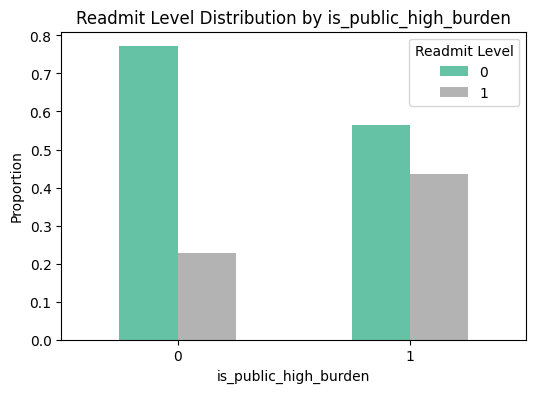

Chi-square test for is_public_high_burden:
Chi2 = 293.33, p-value = 9.3503e-66


In [109]:
ct = pd.crosstab(df['is_public_high_burden'], df['readmit_level'], normalize='index')

ct.plot(kind='bar', stacked=False, colormap='Set2', figsize=(6,4))
plt.title('Readmit Level Distribution by is_public_high_burden')
plt.ylabel('Proportion')
plt.xlabel('is_public_high_burden')
plt.legend(title='Readmit Level')
plt.xticks(rotation=0)
plt.show()

# Chi-square
chi2_result = chi2_contingency(pd.crosstab(df['is_public_high_burden'], df['readmit_level']))
print(f"Chi-square test for is_public_high_burden:\nChi2 = {chi2_result[0]:.2f}, p-value = {chi2_result[1]:.4e}")

The `is_public_high_burden` indicator identifies a subgroup of patients who are significantly more likely to experience hospital readmission (p < 0.001). As shown in the figure, the proportion of readmitted cases is substantially higher among patients flagged as high-burden with public insurance, highlighting the combined impact of socioeconomic disadvantage and clinical complexity.

## Modeling Preparation Summary

The dataset has been fully cleaned, all variables have been processed, and the newly engineered features have been validated through both visualization and statistical testing.  
We are now ready to proceed to the **modeling phase**.

In [128]:
df.to_pickle("diabetes_readmission_processing.pkl")

In [127]:
print(df.shape)
print(df.info())

(57114, 41)
<class 'pandas.core.frame.DataFrame'>
Index: 57114 entries, 0 to 71517
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   patient_nbr            57114 non-null  int64  
 1   time_in_hospital       57114 non-null  int64  
 2   num_lab_procedures     57114 non-null  int64  
 3   num_procedures         57114 non-null  int64  
 4   num_medications        57114 non-null  int64  
 5   number_outpatient      57114 non-null  int64  
 6   number_emergency       57114 non-null  int64  
 7   number_inpatient       57114 non-null  int64  
 8   number_diagnoses       57114 non-null  int64  
 9   diagnosis_tuple_freq   57114 non-null  int64  
 10  race                   57114 non-null  object 
 11  gender                 57114 non-null  object 
 12  age                    57114 non-null  object 
 13  max_glu_serum          57114 non-null  object 
 14  A1Cresult              57114 non-null  object 
